In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import os
import pandas as pd
import matplotlib.pyplot as plt
import json
import h5py

import windIO
import wind
import windWT as wt
import windCAD
import windOF as foam
import windCodes

import winsound

from matplotlib.ticker import FuncFormatter

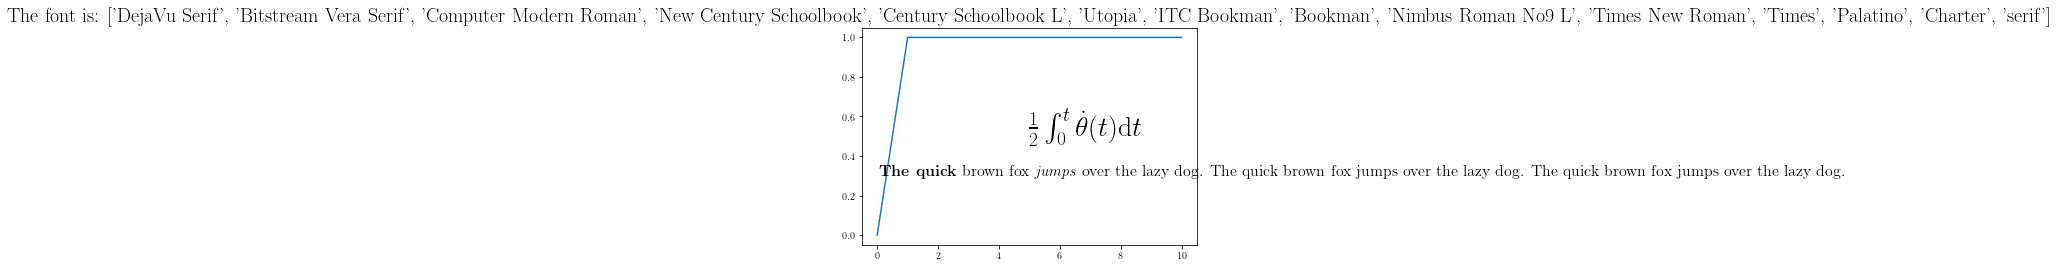

In [3]:
# # turn on latex rendering for matplotlib with Times New Roman font
plt.rc('text', usetex=True)
plt.rc('font', family='serif')

# # change the font to Garamond
# plt.rc('text', usetex=False)
# plt.rcParams['font.family'] = 'serif'
# plt.rcParams['font.serif'] = 'Garamond'
# plt.rcParams['font.sans-serif'] = 'Garamond'

# # change the font to Times New Roman
# plt.rc('text', usetex=False)
# plt.rcParams['font.family'] = 'sans-serif'
# plt.rcParams['font.serif'] = 'Times New Roman'
# plt.rcParams['font.sans-serif'] = 'Times New Roman'

# test the font
plt.figure()
plt.plot([0,1,10],[0,1,1])
txt = "The font is: " + str(plt.rcParams['font.serif'])
plt.title(txt,fontsize=20)
complexEquation = r"$\frac{1}{2} \int_0^t \dot{\theta}(t) \mathrm{d}t$"
plt.text(5,0.5,complexEquation,fontsize=28)
multilineTxt = r"\textbf{The quick} brown fox \textit{jumps} over the lazy dog. The quick brown fox jumps over the lazy dog. The quick brown fox jumps over the lazy dog."
plt.text(0.05,0.3,multilineTxt,fontsize=16)
plt.show()


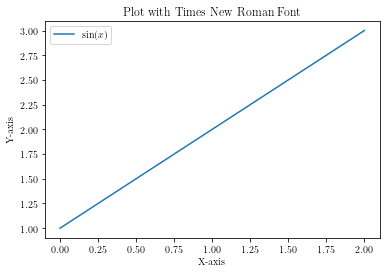

In [4]:
import matplotlib.pyplot as plt

# Set the font for regular text directly
plt.rcParams['font.family'] = 'Times New Roman'

# Example plot with Times New Roman font for regular text
plt.plot([1, 2, 3], label=r'$\sin(x)$')
plt.title('Plot with Times New Roman Font')
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.legend()

# Show the plot
plt.show()


## Basic definitions

In [5]:
les_dir = r"D:/tempData_depot/simData_CandC/wt_tngE2_final/main.infl.t5.r2.s2/"

dir_wtVl_tngE2 = r"D:/tempData_depot/simData_CandC/wt_tngE2/"
dir_wtVl_tngE3 = r"D:/tempData_depot/simData_CandC/wt_tngE3/"

runIDs = ['p1', 'p2', 'p3', 'p4', 'p5',]

dir_wtCp_tngE2 = [r"E:/TNG/rawHFPI/tngE2"+x+"/" for x in runIDs]
dir_wtCp_tngE3 = [r"E:/TNG/rawHFPI/tngE3"+x+"/" for x in runIDs]

saveFigs = True
figDir = les_dir+ r"__plots/"
if not os.path.exists(figDir):
    os.makedirs(figDir)

In [6]:
caseDict = {
    # 'AoAs':     [0.0, 10.0, 20.0, 30.0, 40.0, 45.0, 50.0, 60.0, 70.0, 80.0, 90.0],
    'AoAs':     [0.0, 10.0, 20.0, 30.0, 45.0, 60.0, 70.0, 80.0, 90.0],
    'profile':  {'dir':les_dir+'tngE2.ed.t5.r2.s2', 'probeName':'prof_x0_y0'},
    'p0_Z':     0.0, # [m] probe height
    0.0:        {'dir':les_dir+'tngE2.00d.m1.v1', 'probeName':'probes_WTtaps', 'p0_probeName':'prof_x0_y0'},
    10.0:       {'dir':les_dir+'tngE2.10d.m1.v1', 'probeName':'probes_WTtaps', 'p0_probeName':'prof_x0_y0'},
    20.0:       {'dir':les_dir+'tngE2.20d.m1.v1', 'probeName':'probes_WTtaps', 'p0_probeName':'prof_x0_y0'},
    30.0:       {'dir':les_dir+'tngE2.30d.m1.v1', 'probeName':'probes_WTtaps', 'p0_probeName':'prof_x0_y0'},
    # 40.0:       {'dir':les_dir+'tngE2.40d.m1.v1', 'probeName':'probes_WTtaps', 'p0_probeName':'prof_x0_y0'},
    45.0:       {'dir':les_dir+'tngE2.45d.m1.v1', 'probeName':'probes_WTtaps', 'p0_probeName':'prof_x0_y0'},
    # 50.0:       {'dir':les_dir+'tngE2.50d.m1.v1', 'probeName':'probes_WTtaps', 'p0_probeName':'prof_x0_y0'},
    60.0:       {'dir':les_dir+'tngE2.60d.m1.v1', 'probeName':'probes_WTtaps', 'p0_probeName':'prof_x0_y0'},
    70.0:       {'dir':les_dir+'tngE2.70d.m1.v1', 'probeName':'probes_WTtaps', 'p0_probeName':'prof_x0_y0'},
    80.0:       {'dir':les_dir+'tngE2.80d.m1.v1', 'probeName':'probes_WTtaps', 'p0_probeName':'prof_x0_y0'},
    90.0:       {'dir':les_dir+'tngE2.90d.m1.v1', 'probeName':'probes_WTtaps', 'p0_probeName':'prof_x0_y0'},
}


In [240]:
B = 0.2744
D = 0.183
lScl=1/50.0

Hr = 0.08  # ridge height
roofSlope = np.rad2deg(np.arctan(0.25/12))  # roof slope
He = Hr - D/2.0*np.sin(np.deg2rad(roofSlope))  # eaves height
Havg = np.mean([Hr, He])
H = Havg  # average roof height
print("Hr = {:.5g} m, He = {:.5g} m, Havg = {:.5g} m".format(Hr, He, Havg))

areaFactor_toFSm2 = (1/lScl**2)   # convert mm2 to m2 and normalize by the square of the length scale

fluidDensity = 1.225
fluidKinematicViscosity = 1.48e-5

badTaps = None
# badTaps = [1316, 1807, 2609,]


Hr = 0.08 m, He = 0.078094 m, Havg = 0.079047 m


## Building Geometry

In [8]:
tapFile = r"D:/tempData_depot/simData_CandC/tngTapDefinition.csv"
tapInfo = pd.read_csv(tapFile)

faceID = [1,2,3,4,5,6]
name = ['Roof_1','Roof_2','Wall_1','Wall_2','Wall_3','Wall_4']
note = ['','','','','','']
origin = [[0,0,0.08],
          [0,-0.0915,0.07809375],
          [-0.1372,0,0],
          [0,-0.0915,0],
          [0.1372,0,0],
          [0,0.0915,0],]
basisVectors = [[[1,0,0],[0,0.999783057,0.020828814],[0,-0.020828814,0.999783057]],
                [[1,0,0],[0,0.999783057,-0.020828814],[0,0.020828814,0.999783057]],
                [[0,0,-1],[-1,0,0],[0,1,0]],
                [[1,0,0],[0,0,-1],[0,1,0]],
                [[0,0,1],[1,0,0],[0,1,0]],
                [[-1,0,0],[0,0,1],[0,1,0]],]

origin_plt = [[0, 0],
              [0, 0],
              [0, 0],
              [0, 0],
              [0, 0],
              [0, 0],
              ]

basisVectors_plt = [[[0, 1], [-1, 0]],
                    [[0, 1], [-1, 0]],
                    [[0, 1], [-1, 0]],
                    [[0, 1], [-1, 0]],
                    [[0, 1], [-1, 0]],
                    [[0, 1], [-1, 0]],
                    ]
vertices = [[[-0.091519855,-0.1372],[0,-0.1372],[0,0.1372],[-0.091519855,0.1372],[-0.091519855,-0.1372]],
            [[0,-0.1372],[0.091519855,-0.1372],[0.091519855,0.1372],[0,0.1372],[0,-0.1372]],
            [[-0.0915,-0.2332],[0.0915,-0.2332],[0.0915,-0.15510625],[0,-0.1532],[-0.0915,-0.15510625],[-0.0915,-0.2332]],
            [[0.107519855,-0.1372],[0.185613605,-0.1372],[0.185613605,0.1372],[0.107519855,0.1372],[0.107519855,-0.1372]],
            [[-0.0915,0.2332],[0.0915,0.2332],[0.0915,0.15510625],[0,0.1532],[-0.0915,0.15510625],[-0.0915,0.2332]],
            [[-0.107519855,-0.1372],[-0.185613605,-0.1372],[-0.185613605,0.1372],[-0.107519855,0.1372],[-0.107519855,-0.1372]],]



In [9]:
# Zone Dict definitions

zoneDict_NBCC = [
        {    # Face 1
            0:['NBCC 2020', 'Zone c', np.array([[-0.091519855,-0.1372],[-0.071519855,-0.1372],[-0.071519855,-0.1172],[-0.091519855,-0.1172],[-0.091519855,-0.1372]])],
            1:['NBCC 2020', 'Zone c', np.array([[-0.091519855,0.1172],[-0.071519855,0.1172],[-0.071519855,0.1372],[-0.091519855,0.1372],[-0.091519855,0.1172]])],
            2:['NBCC 2020', 'Zone s', np.array([[-0.071519855,-0.1372],[0,-0.1372],[0,-0.1172],[-0.071519855,-0.1172],[-0.071519855,-0.1372]])],
            3:['NBCC 2020', 'Zone s', np.array([[-0.091519855,-0.1172],[-0.071519855,-0.1172],[-0.071519855,0.1172],[-0.091519855,0.1172],[-0.091519855,-0.1172]])],
            4:['NBCC 2020', 'Zone s', np.array([[-0.071519855,0.1172],[0,0.1172],[0,0.1372],[-0.071519855,0.1372],[-0.071519855,0.1172]])],
            5:['NBCC 2020', 'Zone r', np.array([[-0.071519855,-0.1172],[0,-0.1172],[0,0.1172],[-0.071519855,0.1172],[-0.071519855,-0.1172]])],
        },
        {   # Face 2
            0:['NBCC 2020', 'Zone c', np.array([[0.091519855,-0.1372],[0.071519855,-0.1372],[0.071519855,-0.1172],[0.091519855,-0.1172],[0.091519855,-0.1372]])],
            1:['NBCC 2020', 'Zone c', np.array([[0.091519855,0.1172],[0.071519855,0.1172],[0.071519855,0.1372],[0.091519855,0.1372],[0.091519855,0.1172]])],
            2:['NBCC 2020', 'Zone s', np.array([[0.071519855,-0.1372],[0,-0.1372],[0,-0.1172],[0.071519855,-0.1172],[0.071519855,-0.1372]])],
            3:['NBCC 2020', 'Zone s', np.array([[0.091519855,-0.1172],[0.071519855,-0.1172],[0.071519855,0.1172],[0.091519855,0.1172],[0.091519855,-0.1172]])],
            4:['NBCC 2020', 'Zone s', np.array([[0.071519855,0.1172],[0,0.1172],[0,0.1372],[0.071519855,0.1372],[0.071519855,0.1172]])],
            5:['NBCC 2020', 'Zone r', np.array([[0.071519855,-0.1172],[0,-0.1172],[0,0.1172],[0.071519855,0.1172],[0.071519855,-0.1172]])],
        },
        {   # Face 3
            0:['NBCC 2020', 'Zone e', np.array([[-0.0915,-0.2332],[-0.0715,-0.2332],[-0.0715,-0.154689583],[-0.0915,-0.15510625],[-0.0915,-0.2332]])],
            1:['NBCC 2020', 'Zone e', np.array([[0.0715,-0.2332],[0.0915,-0.2332],[0.0915,-0.15510625],[0.0715,-0.154689583],[0.0715,-0.2332]])],
            2:['NBCC 2020', 'Zone w', np.array([[-0.0715,-0.2332],[0.0715,-0.2332],[0.0715,-0.154689583],[0,-0.1532],[-0.0715,-0.154689583],[-0.0715,-0.2332]])],
        },
        {   # Face 4
            0:['NBCC 2020', 'Zone e', np.array([[0.107519855,-0.1372],[0.185613605,-0.1372],[0.185613605,-0.1172],[0.107519855,-0.1172],[0.107519855,-0.1372]])],
            1:['NBCC 2020', 'Zone e', np.array([[0.107519855,0.1172],[0.185613605,0.1172],[0.185613605,0.1372],[0.107519855,0.1372],[0.107519855,0.1172]])],
            2:['NBCC 2020', 'Zone w', np.array([[0.107519855,-0.1172],[0.185613605,-0.1172],[0.185613605,0.1172],[0.107519855,0.1172],[0.107519855,-0.1172]])],
        },
        {   # Face 5
            0:['NBCC 2020', 'Zone e', np.array([[-0.0915,0.2332],[-0.0715,0.2332],[-0.0715,0.154689583],[-0.0915,0.15510625],[-0.0915,0.2332]])],
            1:['NBCC 2020', 'Zone e', np.array([[0.0715,0.2332],[0.0915,0.2332],[0.0915,0.15510625],[0.0715,0.154689583],[0.0715,0.2332]])],
            2:['NBCC 2020', 'Zone w', np.array([[-0.0715,0.2332],[0.0715,0.2332],[0.0715,0.154689583],[0,0.1532],[-0.0715,0.154689583],[-0.0715,0.2332]])],
        },
        {   # Face 6
            0:['NBCC 2020', 'Zone e', np.array([[-0.107519855,-0.1372],[-0.185613605,-0.1372],[-0.185613605,-0.1172],[-0.107519855,-0.1172],[-0.107519855,-0.1372]])],
            1:['NBCC 2020', 'Zone e', np.array([[-0.107519855,0.1172],[-0.185613605,0.1172],[-0.185613605,0.1372],[-0.107519855,0.1372],[-0.107519855,0.1172]])],
            2:['NBCC 2020', 'Zone w', np.array([[-0.107519855,-0.1172],[-0.185613605,-0.1172],[-0.185613605,0.1172],[-0.107519855,0.1172],[-0.107519855,-0.1172]])],
        },
]

zoneDict_ASCE = [
        {    # Face 1
            0:['ASCE 7-22', 'Zone 3', np.array([[-0.0435, 0.1372], [-0.0915, 0.1372], [-0.0915, 0.0892], [-0.0755, 0.0892], [-0.0755, 0.1212], [-0.0435, 0.1212], [-0.0435, 0.1372], ])],
            1:['ASCE 7-22', 'Zone 3', np.array([[-0.0915, -0.0892], [-0.0915, -0.1372], [-0.0435, -0.1372], [-0.0435, -0.1212], [-0.0755, -0.1212], [-0.0755, -0.0892], [-0.0915, -0.0892], ])],
            2:['ASCE 7-22', 'Zone 2', np.array([[0, 0.1372], [-0.0435, 0.1372], [-0.0435, 0.1212], [-0.0755, 0.1212], [-0.0755, 0.0892], [-0.0915, 0.0892], [-0.0915, -0.0892], 
                                                [-0.0755, -0.0892], [-0.0755, -0.1212], [-0.0435, -0.1212], [-0.0435, -0.1372], [0, -0.1372], [0, -0.0892], [-0.0435, -0.0892], 
                                                [-0.0435, 0.0892], [0, 0.0892], [0, 0.1372], ])],
            3:['ASCE 7-22', 'Zone 1', np.array([[0, 0.0892], [-0.0435, 0.0892], [-0.0435, -0.0892], [0, -0.0892], [0, 0.0892], ])],
        },
        {   # Face 2
            0:['ASCE 7-22', 'Zone 3', np.array([[0.0435, 0.1372], [0.0915, 0.1372], [0.0915, 0.0892], [0.0755, 0.0892], [0.0755, 0.1212], [0.0435, 0.1212], [0.0435, 0.1372], ])],
            1:['ASCE 7-22', 'Zone 3', np.array([[0.0915, -0.0892], [0.0915, -0.1372], [0.0435, -0.1372], [0.0435, -0.1212], [0.0755, -0.1212], [0.0755, -0.0892], [0.0915, -0.0892], ])],
            2:['ASCE 7-22', 'Zone 2', np.array([[0, 0.1372], [0.0435, 0.1372], [0.0435, 0.1212], [0.0755, 0.1212], [0.0755, 0.0892], [0.0915, 0.0892], [0.0915, -0.0892], 
                                                [0.0755, -0.0892], [0.0755, -0.1212], [0.0435, -0.1212], [0.0435, -0.1372], [0, -0.1372], [0, -0.0892], [0.0435, -0.0892], 
                                                [0.0435, 0.0892], [0, 0.0892], [0, 0.1372], ])],
            3:['ASCE 7-22', 'Zone 1', np.array([[0, 0.0892], [0.0435, 0.0892], [0.0435, -0.0892], [0, -0.0892], [0, 0.0892], ])],
        },
        {   # Face 3
            0:['ASCE 7-22', 'Zone 4', np.array([[-0.0715,-0.2332],[0.0715,-0.2332],[0.0715,-0.154689583],[0,-0.1532],[-0.0715,-0.154689583],[-0.0715,-0.2332]])],
            1:['ASCE 7-22', 'Zone 5', np.array([[-0.0915,-0.2332],[-0.0715,-0.2332],[-0.0715,-0.154689583],[-0.0915,-0.15510625],[-0.0915,-0.2332]])],
            2:['ASCE 7-22', 'Zone 5', np.array([[0.0715,-0.2332],[0.0915,-0.2332],[0.0915,-0.15510625],[0.0715,-0.154689583],[0.0715,-0.2332]])],
        },
        {   # Face 4
            0:['ASCE 7-22', 'Zone 5', np.array([[0.107519855,-0.1372],[0.185613605,-0.1372],[0.185613605,-0.1172],[0.107519855,-0.1172],[0.107519855,-0.1372]])],
            1:['ASCE 7-22', 'Zone 5', np.array([[0.107519855,0.1172],[0.185613605,0.1172],[0.185613605,0.1372],[0.107519855,0.1372],[0.107519855,0.1172]])],
            2:['ASCE 7-22', 'Zone 4', np.array([[0.107519855,-0.1172],[0.185613605,-0.1172],[0.185613605,0.1172],[0.107519855,0.1172],[0.107519855,-0.1172]])],
        },
        {   # Face 5
            0:['ASCE 7-22', 'Zone 5', np.array([[-0.0915,0.2332],[-0.0715,0.2332],[-0.0715,0.154689583],[-0.0915,0.15510625],[-0.0915,0.2332]])],
            1:['ASCE 7-22', 'Zone 5', np.array([[0.0715,0.2332],[0.0915,0.2332],[0.0915,0.15510625],[0.0715,0.154689583],[0.0715,0.2332]])],
            2:['ASCE 7-22', 'Zone 4', np.array([[-0.0715,0.2332],[0.0715,0.2332],[0.0715,0.154689583],[0,0.1532],[-0.0715,0.154689583],[-0.0715,0.2332]])],
        },
        {   # Face 6
            0:['ASCE 7-22', 'Zone 5', np.array([[-0.107519855,-0.1372],[-0.185613605,-0.1372],[-0.185613605,-0.1172],[-0.107519855,-0.1172],[-0.107519855,-0.1372]])],
            1:['ASCE 7-22', 'Zone 5', np.array([[-0.107519855,0.1172],[-0.185613605,0.1172],[-0.185613605,0.1372],[-0.107519855,0.1372],[-0.107519855,0.1172]])],
            2:['ASCE 7-22', 'Zone 4', np.array([[-0.107519855,-0.1172],[-0.185613605,-0.1172],[-0.185613605,0.1172],[-0.107519855,0.1172],[-0.107519855,-0.1172]])],
        },
]

# file = caseDir+'NBCC_zoneDict.json'
# with open(file, 'w') as f:
#     json.dump(zoneDict,f, indent=4, separators=(',', ':'))

In [10]:
# nominalPanelAreas=[1.0e-4, 2.45e-4, 4.8e-4, 7.1e-4, 1e-3], #[5e-5, 8e-5, 1.5e-4, 5e-4]
# nominalPanelAreas=[4.4e-5, 8.15e-5, 1.3e-4, 5e-4, 6.8e-4, 1.3e-3,]  # Final! All are tested. 1.3e-3 results in blunt edge zones in the walls but no error.
nominalPanelAreas=[4.4e-5, 8.15e-5, 1.3e-4, 5.25e-4, 6.8e-4, 1.3e-3,]  # 5e-4 causes problems in ASCE 7-22 zone 2 
# nominalPanelAreas=[1.3e-3,]
# nominalPanelAreas=[4.8e-4, 7.2e-4, 1e-3]

faces_NBCC = []
for i,f in enumerate(faceID):
    idx = tapInfo.index[tapInfo.faceID == f]
    tapCoords = np.transpose(np.array([tapInfo.x[idx], tapInfo.y[idx]]))
    tapNos = np.array(tapInfo.tapNo[idx],dtype=int)
    idxOrig = idx

    fc = windCAD.face(
                name=name[i],
                ID=f,
                origin=origin[i],
                basisVectors=basisVectors[i],
                origin_plt=origin_plt[i],
                basisVectors_plt=basisVectors_plt[i],
                vertices=vertices[i],
                tapNo=tapNos,
                tapIdx=idxOrig,
                tapName=None,
                tapCoord=tapCoords,
                zoneDict=zoneDict_NBCC[i],
                nominalPanelAreas=nominalPanelAreas,
                numOfNominalPanelAreas=3,
                badTaps=badTaps,
                allBldgTaps=np.array(tapInfo.tapNo,dtype=int),
                )
    # fc.plot(figSize=[20,15], overlayPanels=True, overlayTaps=True, overlayTribs=True, overlayZones=True)
    faces_NBCC.append(fc)

faces_ASCE = []
for i,f in enumerate(faceID):
    idx = tapInfo.index[tapInfo.faceID == f]
    tapCoords = np.transpose(np.array([tapInfo.x[idx], tapInfo.y[idx]]))
    tapNos = np.array(tapInfo.tapNo[idx],dtype=int)
    idxOrig = idx

    fc = windCAD.face(
                name=name[i],
                ID=f,
                origin=origin[i],
                basisVectors=basisVectors[i],
                origin_plt=origin_plt[i],
                basisVectors_plt=basisVectors_plt[i],
                vertices=vertices[i],
                tapNo=tapNos,
                tapIdx=idxOrig,
                tapName=None,
                tapCoord=tapCoords,
                zoneDict=zoneDict_ASCE[i],
                nominalPanelAreas=nominalPanelAreas,
                numOfNominalPanelAreas=3,
                badTaps=badTaps,
                allBldgTaps=np.array(tapInfo.tapNo,dtype=int),
                )
    # fc.plot(figSize=[20,15], overlayPanels=True, overlayTaps=True, overlayTribs=True, overlayZones=True)
    faces_ASCE.append(fc)
# file = caseDir+'ttu_bldgGeom.json'
# allFaces.writeToFile(file_basic=file)

Generating panels ...


c:\ProgramData\Anaconda3\lib\site-packages\shapely\constructive.py:963: RuntimeWarning: invalid value encountered in voronoi_polygons
  return lib.voronoi_polygons(geometry, tolerance, extend_to, only_edges, **kwargs)
c:\ProgramData\Anaconda3\lib\site-packages\shapely\constructive.py:963: RuntimeWarning: invalid value encountered in voronoi_polygons
  return lib.voronoi_polygons(geometry, tolerance, extend_to, only_edges, **kwargs)
c:\ProgramData\Anaconda3\lib\site-packages\shapely\constructive.py:963: RuntimeWarning: invalid value encountered in voronoi_polygons
  return lib.voronoi_polygons(geometry, tolerance, extend_to, only_edges, **kwargs)
c:\ProgramData\Anaconda3\lib\site-packages\shapely\constructive.py:963: RuntimeWarning: invalid value encountered in voronoi_polygons
  return lib.voronoi_polygons(geometry, tolerance, extend_to, only_edges, **kwargs)
c:\ProgramData\Anaconda3\lib\site-packages\shapely\constructive.py:963: RuntimeWarning: invalid value encountered in voronoi_pol

Done generating panels ...
Error summary in paneling:
{
    "NBCC 2020 -- Zone c": {
        "nom. areas idxs with tiling errors [4.4e-05, 8.15e-05, 0.00013, 0.000525, 0.00068, 0.0013]": [],
        "tap idxs with weight errors": {
            "A=4.4e-05": [],
            "A=8.15e-05": [],
            "A=0.00013": [],
            "A=0.000525": [],
            "A=0.00068": [],
            "A=0.0013": []
        }
    },
    "NBCC 2020 -- Zone s": {
        "nom. areas idxs with tiling errors [4.4e-05, 8.15e-05, 0.00013, 0.000525, 0.00068, 0.0013]": [],
        "tap idxs with weight errors": {
            "A=4.4e-05": [],
            "A=8.15e-05": [],
            "A=0.00013": [],
            "A=0.000525": [],
            "A=0.00068": [],
            "A=0.0013": []
        }
    },
    "NBCC 2020 -- Zone r": {
        "nom. areas idxs with tiling errors [4.4e-05, 8.15e-05, 0.00013, 0.000525, 0.00068, 0.0013]": [],
        "tap idxs with weight errors": {
            "A=4.4e-05": [],
     

c:\ProgramData\Anaconda3\lib\site-packages\shapely\constructive.py:963: RuntimeWarning: invalid value encountered in voronoi_polygons
  return lib.voronoi_polygons(geometry, tolerance, extend_to, only_edges, **kwargs)
c:\ProgramData\Anaconda3\lib\site-packages\shapely\constructive.py:963: RuntimeWarning: invalid value encountered in voronoi_polygons
  return lib.voronoi_polygons(geometry, tolerance, extend_to, only_edges, **kwargs)
c:\ProgramData\Anaconda3\lib\site-packages\shapely\constructive.py:963: RuntimeWarning: invalid value encountered in voronoi_polygons
  return lib.voronoi_polygons(geometry, tolerance, extend_to, only_edges, **kwargs)
c:\ProgramData\Anaconda3\lib\site-packages\shapely\constructive.py:963: RuntimeWarning: invalid value encountered in voronoi_polygons
  return lib.voronoi_polygons(geometry, tolerance, extend_to, only_edges, **kwargs)
c:\ProgramData\Anaconda3\lib\site-packages\shapely\constructive.py:963: RuntimeWarning: invalid value encountered in voronoi_pol

Done generating panels ...
Error summary in paneling:
{
    "NBCC 2020 -- Zone c": {
        "nom. areas idxs with tiling errors [4.4e-05, 8.15e-05, 0.00013, 0.000525, 0.00068, 0.0013]": [],
        "tap idxs with weight errors": {
            "A=4.4e-05": [],
            "A=8.15e-05": [],
            "A=0.00013": [],
            "A=0.000525": [],
            "A=0.00068": [],
            "A=0.0013": []
        }
    },
    "NBCC 2020 -- Zone s": {
        "nom. areas idxs with tiling errors [4.4e-05, 8.15e-05, 0.00013, 0.000525, 0.00068, 0.0013]": [],
        "tap idxs with weight errors": {
            "A=4.4e-05": [],
            "A=8.15e-05": [],
            "A=0.00013": [],
            "A=0.000525": [],
            "A=0.00068": [],
            "A=0.0013": []
        }
    },
    "NBCC 2020 -- Zone r": {
        "nom. areas idxs with tiling errors [4.4e-05, 8.15e-05, 0.00013, 0.000525, 0.00068, 0.0013]": [],
        "tap idxs with weight errors": {
            "A=4.4e-05": [],
     

In [11]:
bldg = wind.bldgCp(bldgName='TTU_1to50_TNG',
                faces=faces_ASCE,
                H=H, He=He, Hr=Hr,
                D=D,B=B,roofSlope=roofSlope,lScl=lScl,
                caseName='GeomDefinition',
                AoA_zero_deg_basisVector=[1,0],
                AoA_rotation_direction='CCW',
                badTaps=badTaps,
                )
print(json.dumps(bldg.panelingErrors, indent=4, separators=(',', ':')))

Refreshing GeomDefinition...
Verifying data ...
Done refreshing GeomDefinition.

{
    "Face 1":{
        "ASCE 7-22 -- Zone 3":{
            "nom. areas idxs with tiling errors [4.4e-05, 8.15e-05, 0.00013, 0.000525, 0.00068, 0.0013]":[],
            "tap idxs with weight errors":{
                "A=4.4e-05":[],
                "A=8.15e-05":[],
                "A=0.00013":[],
                "A=0.000525":[],
                "A=0.00068":[],
                "A=0.0013":[]
            }
        },
        "ASCE 7-22 -- Zone 2":{
            "nom. areas idxs with tiling errors [4.4e-05, 8.15e-05, 0.00013, 0.000525, 0.00068, 0.0013]":[],
            "tap idxs with weight errors":{
                "A=4.4e-05":[],
                "A=8.15e-05":[],
                "A=0.00013":[],
                "A=0.000525":[],
                "A=0.00068":[],
                "A=0.0013":[]
            }
        },
        "ASCE 7-22 -- Zone 1":{
            "nom. areas idxs with tiling errors [4.4e-05, 8.15e-05

### Plots

(-0.25651999999999997,
 0.25651999999999997,
 -0.20417496549999997,
 0.20417496549999997)

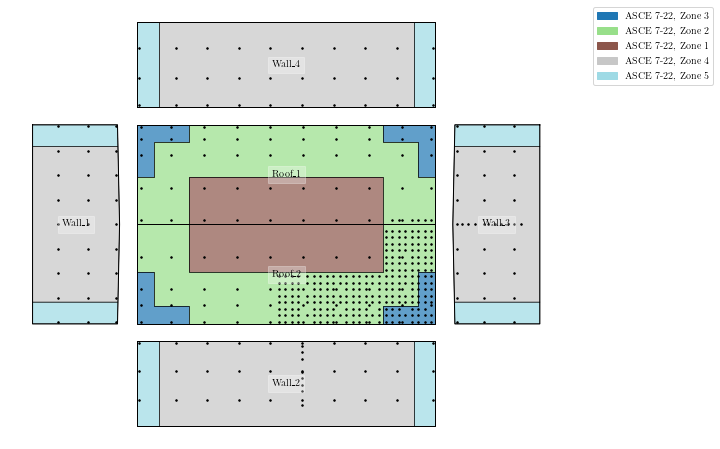

In [12]:
fig = plt.figure(figsize=[10,8])
ax = fig.add_subplot()

bldg.plotEdges(ax=ax,showName=True)
bldg.plotZones(ax=ax)
bldg.plotTaps(ax=ax)
# bldg.plotTribs(ax=ax)
# bldg.plotPanels(ax=ax,aIdx=2)

ax.axis('equal')
ax.axis('off')
# if saveFigs:
#     fig.savefig(figDir+"tapLayout.svg",format='svg',dpi=1200, bbox_inches='tight')



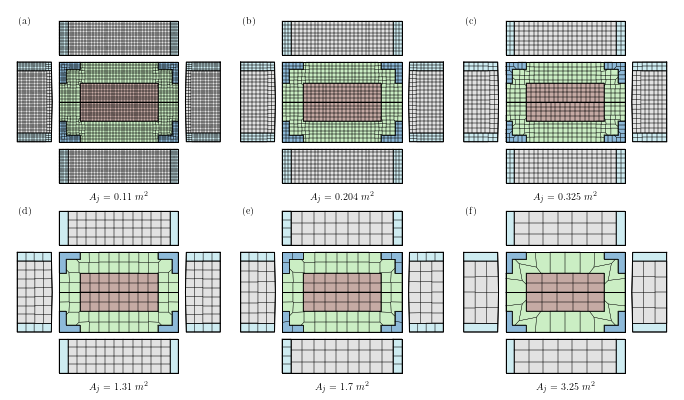

In [13]:
fig, axs = bldg.plotPanels_AllAreas(figsize=[12,7.0], nCols=3,
    areaUnit=r'$m^2$', areaFactor=areaFactor_toFSm2, areaFmt='{:2.3g}',)

if saveFigs:
    fig.savefig(figDir+"nominalPanelAreas_ASCE.svg",format='svg',dpi=300, bbox_inches='tight')

## Wind field

### LES wind field

In [154]:

lesVel_E2 = foam.readVelProfile(caseDir=caseDict['profile']['dir'], probeName=caseDict['profile']['probeName'],H=H, readFromNPY_file=True, writeToFile=True, 
                                kwargs_profile={'workSect_zLim':[0, 0.5],  'lScl':lScl, 'nSpectAvg':16})
lesVel_E2.name = "LES$(z_0=0.01m)$"
lesVel_E2.SpectH.name = lesVel_E2.name

lesVel_E2.kwargs_z0_fit_Iu = {'fitTo':'Iu', # 'Iu' or 'U'
                            'uStar_init':1.0, 
                            'z0_init':0.001, 
                            'kwargs_z0Fit':{'z0i':[1e-10,1.0]}}
_ = lesVel_E2.fit_z0(debugMode=False, )

# lesVel_E3 = foam.processVelProfile(caseDir=dir_lesE3_00, probeName='probes.V1',H=H, trimTimeSegs=[[0,1.0]])
# lesVel_E3.name = "LES(z_0=0.087m)"

### Wind tunnel

D:\OneDrive - The University of Western Ontario\Documents\PhD\Thesis\CodeRepositories\windCalc\src\wind.py:3021: RuntimeWarning: invalid value encountered in power
  return np.divide(7.5*eta * np.power(0.538 + 0.09*np.log(Z/self.z0), p),


No velocity time history found for ESDU-85 ($z_0=0.0083 m$). Skipping velocity statistics calculation.
No velocity time history found for ESDU-85 ($z_0=0.000928 m$). Skipping velocity statistics calculation.
Fitted z0 = 0.0081m @FS
0.00016113281448388675


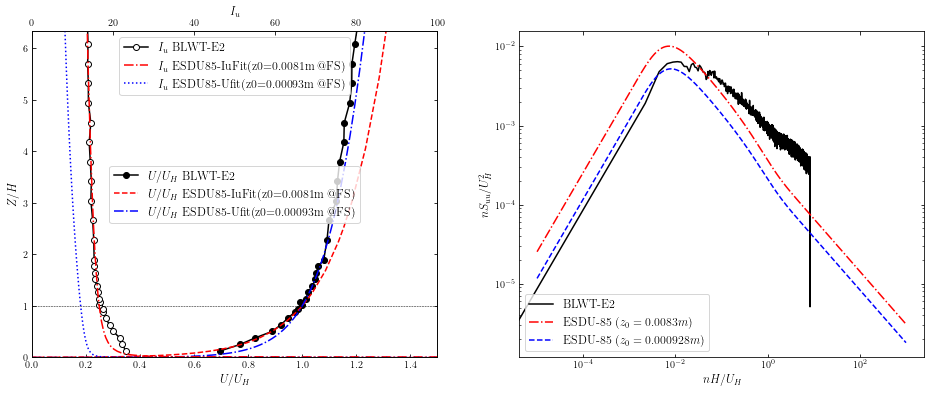

In [152]:
keepTH = True

temp = h5py.File(dir_wtVl_tngE2+"tngE2Fr1_forPython.mat", 'r')
wtVel_E2 = wind.profile(name="BLWT-E2", Z=temp['Z'][0][()],UofT=temp['UofT'][()],VofT=temp['VofT'][()],WofT=temp['WofT'][()],H=H,dt=temp['dt'][0][0],nSpectAvg=64, 
                        workSect_zLim=[0, 0.5], lScl=lScl,
                        keepTH=keepTH)
wtVel_E2.kwargs_z0_fit = {'fitTo':'Iu', # 'Iu' or 'U'
                        'uStar_init':1.0, 
                        'z0_init':0.001, 
                        'kwargs_z0Fit':{'z0i':[1e-10,1.0]}}
wtVel_E2.fit_z0(debugMode=True, )
print(wtVel_E2.z0_Iu)



# temp = h5py.File(dir_wtVl_tngE3+"tngE3Fr1_forPython.mat", 'r')
# wtVel_E3 = wind.profile(name="BLWT-E3", Z=temp['Z'][0][()],UofT=temp['UofT'][()],VofT=temp['VofT'][()],WofT=temp['WofT'][()],H=H,dt=temp['dt'][0][0],nSpectAvg=64, keepTH=keepTH)


In [324]:
vel = wind.Profiles([wtVel_E2, lesVel_E2,])

wtVel_E2_es74 = wtVel_E2.copy()
_ = wtVel_E2_es74.fit_z0(debugMode=False, ESDUversion='ESDU74')

# esdu74_E2 = wind.ESDU74(z0=wtVel_E2_es74.z0_Iu/wtVel_E2_es74.lScl, Zref=H/lScl, Uref=25.0, Z=np.logspace(-1,2,100))
# esdu85_E2 = wind.ESDU85(z0=wtVel_E2.z0_Iu/wtVel_E2.lScl, Zref=H/lScl, Uref=25.0, Z=np.logspace(-1,2,100))
esdu74_E2 = wind.ESDU74(z0=0.01, Zref=H/lScl, Uref=25.0, Z=np.logspace(-1,2,100))
esdu85_E2 = wind.ESDU85(z0=0.01, Zref=H/lScl, Uref=25.0, Z=np.logspace(-1,2,100))


Fitted z0 = 0.0049m @FS


D:\OneDrive - The University of Western Ontario\Documents\PhD\Thesis\CodeRepositories\windCalc\src\wind.py:741: RuntimeWarning: invalid value encountered in log
  U_func = lambda Z, uStar, z0: uStar / VON_KARMAN_CONST * np.log((Z - d) / z0)


## Surface pressure, $C_p$

In [ ]:
peakSpecs = wind.DEFAULT_PEAK_SPECS
peakSpecs['Num_seg'] = 10
peakSpecs['Duration'] = 10
peakSpecs['prob_non_excd'] = 0.8

### Load CFD Cp

In [ ]:
allPres = []
nmin = 1000000000000
tCutIdx = 14000
readFromNPY_file=True
AoA_final = []
p0_profs = []
for i, aoa in enumerate(caseDict['AoAs']):
    p,probes,time = foam.readSurfacePressure(caseDir=caseDict[aoa]['dir'], probeName=caseDict[aoa]['probeName'], readFromNPY_file=readFromNPY_file, writeToFile=True)
    p0,probes_0,time_0  = foam.readSurfacePressure(caseDir=caseDict[aoa]['dir'], probeName=caseDict[aoa]['p0_probeName'], readFromNPY_file=readFromNPY_file, writeToFile=True)

    if p.shape[1] >= tCutIdx:
        # get the indices of common time steps between p0 and p. Don't apply tCutIdx here
        idx_p0 = np.where(np.isin(time_0, time))[0]
        idx_p = np.where(np.isin(time, time_0))[0]
        print(f"Shape of p0: {p0.shape}")
        print(f"Shape of p: {p.shape}")

        p = p[:, idx_p]
        p0 = p0[:, idx_p0]

        allPres.append(p - p0[-10, :])
        AoA_final.append(aoa)
        print(p.shape)
        nmin = min(nmin, p.shape[1])
        # p0_profs.append(p0_prof)

for i in range(len(allPres)):
    allPres[i] = allPres[i][:, :nmin]

allPressure = np.array(allPres)

print(allPressure.shape)

Processing OpenFOAM case:	D:/tempData_depot/simData_CandC/wt_tngE2_final/main.infl.t5.r2.s2/tngE2.00d.m1.v1
Probe read from:		D:/tempData_depot/simData_CandC/wt_tngE2_final/main.infl.t5.r2.s2/tngE2.00d.m1.v1/postProcessing/probes_WTtaps
  >> Reading probe data ...
  >> Reading data from NPY file.
             << Done!
  >> Finished reading probe data.
Processing OpenFOAM case:	D:/tempData_depot/simData_CandC/wt_tngE2_final/main.infl.t5.r2.s2/tngE2.00d.m1.v1
Probe read from:		D:/tempData_depot/simData_CandC/wt_tngE2_final/main.infl.t5.r2.s2/tngE2.00d.m1.v1/postProcessing/prof_x0_y0
  >> Reading probe data ...
  >> Reading data from NPY file.
             << Done!
  >> Finished reading probe data.
Shape of p0: (29, 27196)
Shape of p: (456, 27196)
(456, 27196)
Processing OpenFOAM case:	D:/tempData_depot/simData_CandC/wt_tngE2_final/main.infl.t5.r2.s2/tngE2.10d.m1.v1
Probe read from:		D:/tempData_depot/simData_CandC/wt_tngE2_final/main.infl.t5.r2.s2/tngE2.10d.m1.v1/postProcessing/probes_WT

In [ ]:
# casename = 'tngE2.00d.m1.v1'
# pres, pts, time_p, = foam.readSurfacePressure(caseDir=les_dir+casename, probeName='probes_WTtaps', )
# pres = np.expand_dims(pres.T, axis=0)
# print(pres.shape)
dt = np.diff(time).mean()
# add one dimension as a first dimension of pres


LES_Cp = wind.bldgCp(
                    bldgName=bldg.name,
                    # name=bldg.name + 'LES',
                    faces=bldg.faces,
                    H=H,D=D,B=B,roofSlope=roofSlope,lScl=lScl,
                    AoA_zero_deg_basisVector=bldg.AoA_zero_deg_basisVector,
                    AoA_rotation_direction=bldg.AoA_rotation_direction,
                    caseName='LES',
                    refProfile=lesVel_E2,
                    samplingFreq=1/dt,
                    Uref_input=lesVel_E2.Uh,
                    Uref_FS=25.0,
                    AoA=AoA_final, #caseDict['AoAs'],
                    CpOfT=None,
                    notes_Cp='---',
                    badTaps=None,
                    reReferenceCpToH=False,
                    pOfT=allPressure,
                    # p0ofT=p0_prof.pOfT[:nmin,-10],
                    CpStats=None,
                    peakSpecs=peakSpecs,
                    CpStats_fields=['mean','std','peak','skewness','kurtosis'],
                    keepTH=True,
                    )

Refreshing LES...
Verifying data ...
Computing Cp time history ...
Uref = [12.55060702 12.55060702 12.55060702 12.55060702 12.55060702 12.55060702
 12.55060702 12.55060702 12.55060702]
Shape of self.pOfT = (9, 456, 14582)
Shape of p0ofT = ()
Shape of pOfT = (9, 456, 14582)
Shape of self.fluidDensity = ()
Computing Cp statistics ...
Computing area-averaging ...
    Computing area-averaging for face Roof_1 ...
    Computing area-averaging for face Roof_2 ...
    Computing area-averaging for face Wall_1 ...
    Computing area-averaging for face Wall_2 ...
    Computing area-averaging for face Wall_3 ...
    Computing area-averaging for face Wall_4 ...
Done refreshing LES.



### Wind tunnel data

In [17]:
analogChannels_idxs={
                'main_pitot': 0,
                'xref_pitot': 2,
            }
pressureExtraChannels_tapNos={
                'main_pitot_zero': 3009,
                'main_pitot_q': 3010,
                '20inch_pitot_zero': 3007,
                '20inch_pitot_q': 3008,
                'Uh_pitot_zero': 3005,
                'Uh_pitot_q': 3006,
            }

mainRefPitotChnlIdx = 2
Zpitot = 1.48
Ntaps = 456
lowpassFreq=200.0

(65600,)


In [18]:
# cps_OP = []
i, rID = 0, runIDs[0]
# for i, rID in enumerate(runIDs):
print(">> Processing: OP-"+rID)
cp_raw = wt.BLWTL_HFPI(
    caseDir=dir_wtCp_tngE2[i],
    userNotes=None,
    Z_MainPitot=Zpitot,
    analogChannels_idxs=analogChannels_idxs,
    pressureExtraChannels_tapNos=pressureExtraChannels_tapNos,
    lowpassFreq=lowpassFreq,
    Ntaps=Ntaps,
    AoAsToRead=caseDict['AoAs'],
)
winsound.Beep(1000, 1000)
print("      Loaded raw data")
print(cp_raw.description)


>> Processing: OP-p1
Reading HFPI data from: E:/TNG/rawHFPI/tngE2p1/
   Reading file: E:/TNG/rawHFPI/tngE2p1/TNGp1E02R001P001a.pssd
   Reading file: E:/TNG/rawHFPI/tngE2p1/TNGp1E02R001P002a.pssd
       AoA 5.0 is not in the list of AoAs to read: [0.0, 10.0, 20.0, 30.0, 45.0, 60.0, 70.0, 80.0, 90.0]. Skipping.
   Reading file: E:/TNG/rawHFPI/tngE2p1/TNGp1E02R001P003a.pssd
   Reading file: E:/TNG/rawHFPI/tngE2p1/TNGp1E02R001P004a.pssd
       AoA 15.0 is not in the list of AoAs to read: [0.0, 10.0, 20.0, 30.0, 45.0, 60.0, 70.0, 80.0, 90.0]. Skipping.
   Reading file: E:/TNG/rawHFPI/tngE2p1/TNGp1E02R001P005a.pssd
   Reading file: E:/TNG/rawHFPI/tngE2p1/TNGp1E02R001P006a.pssd
       AoA 25.0 is not in the list of AoAs to read: [0.0, 10.0, 20.0, 30.0, 45.0, 60.0, 70.0, 80.0, 90.0]. Skipping.
   Reading file: E:/TNG/rawHFPI/tngE2p1/TNGp1E02R001P007a.pssd
   Reading file: E:/TNG/rawHFPI/tngE2p1/TNGp1E02R001P008a.pssd
       AoA 35.0 is not in the list of AoAs to read: [0.0, 10.0, 20.0, 30.0, 4

#### Arrange the raw data to match LES $T^*$ (including folding as necessary)

In [247]:
print(cp_raw.CpTH.shape)

(9, 456, 59976)


In [249]:
tMax_WT = np.mean(LES_Cp.T_star) * H / np.mean(cp_raw.Uref)
dt = 1/np.mean(cp_raw.sampleRate)
tMax_Idx = int(tMax_WT/dt)

N_tot = cp_raw.CpTH.shape[-1]
N_folds = int(N_tot/tMax_Idx)
print(f" WT has {N_tot} time steps. Splitting into {N_folds} folds of {tMax_Idx} time steps each.")

# # the velocity can't be scaled directly because the test speed is different from that of the HFPI
# speedRatio = wtVel_E2.Uh / np.mean(cp_raw.Uref)
# tMax_Idx_vel = int(tMax_WT*speedRatio*wtVel_E2.samplingFreq)
# wtVel_E2.UofT = wtVel_E2.UofT[:,:tMax_Idx_vel]
# wtVel_E2.VofT = wtVel_E2.VofT[:,:tMax_Idx_vel]
# wtVel_E2.WofT = wtVel_E2.WofT[:,:tMax_Idx_vel]
# wtVel_E2.t = wtVel_E2.t[:tMax_Idx_vel]
# wtVel_E2.Refresh()


 WT has 59976 time steps. Splitting into 58 folds of 1021 time steps each.


In [251]:
# print(cp_raw.CpTH.shape)

# WT_cp = wind.bldgCp(
#                 bldgName=bldg.name + 'BLWT',
#                 faces=bldg.faces,
#                 H=H,D=D,B=B,roofSlope=roofSlope,lScl=lScl,
#                 AoA_zero_deg_basisVector=bldg.AoA_zero_deg_basisVector,
#                 AoA_rotation_direction=bldg.AoA_rotation_direction,
#                 caseName='OP_ASCE_C&C_'+rID,
#                 refProfile=wtVel_E2,
#                 Zref_input=cp_raw.Z_MainPitot,
#                 Uref_input=cp_raw.Uref,
#                 Uref_FS=25.0,
#                 samplingFreq=cp_raw.sampleRate,
#                 AoA=cp_raw.AoA,
#                 CpOfT=cp_raw.CpTH[:,:,:tMax_Idx],
#                 notes_Cp=cp_raw.description,
#                 badTaps=None,
#                 reReferenceCpToH=True,
#                 pOfT=None,
#                 p0ofT=None,
#                 CpStats=None,
#                 peakSpecs=peakSpecs,
#                 CpStats_fields=['mean','std','peak','skewness','kurtosis'],
#                 keepTH=True,
#                 )
# WT_cp.name = 'BLWT'
# print(f"Shape of CpTH: {WT_cp.CpOfT.shape}")
# winsound.Beep(1500, 1000)
# print("      << Complete!")

# WT_cp.profile.fit_z0(debugMode=False,)
# # cps_OP.append(cp)

# # del cp_raw, cp

(9, 456, 59976)
Re-scaling profile to match Uref ...
    Uref_avg = 12.475 m/s
    U_ref_prof = 7.582 m/s
    U_ratio = 1.645
    time_ratio = 0.608
Refreshing OP_ASCE_C&C_p1...
Verifying data ...
Computing Cp statistics ...
Computing area-averaging ...
    Computing area-averaging for face Roof_1 ...
    Computing area-averaging for face Roof_2 ...
    Computing area-averaging for face Wall_1 ...
    Computing area-averaging for face Wall_2 ...
    Computing area-averaging for face Wall_3 ...
    Computing area-averaging for face Wall_4 ...
Done refreshing OP_ASCE_C&C_p1.

Shape of CpTH: (9, 456, 1021)
      << Complete!
Fitted z0 = 0.0081m @FS


D:\OneDrive - The University of Western Ontario\Documents\PhD\Thesis\CodeRepositories\windCalc\src\wind.py:741: RuntimeWarning: invalid value encountered in log
  uStar, z0 = res.x


0.00016113281448388675

In [285]:
cps_OP = []
for i in range(N_folds):
    cp = wind.bldgCp(
                    bldgName=bldg.name + 'BLWT-' + str(i),
                    faces=bldg.faces,
                    H=H,D=D,B=B,roofSlope=roofSlope,lScl=lScl,
                    AoA_zero_deg_basisVector=bldg.AoA_zero_deg_basisVector,
                    AoA_rotation_direction=bldg.AoA_rotation_direction,
                    caseName='OP_ASCE_C&C_'+rID,
                    refProfile=wtVel_E2,
                    Zref_input=cp_raw.Z_MainPitot,
                    Uref_input=cp_raw.Uref,
                    Uref_FS=25.0,
                    samplingFreq=cp_raw.sampleRate,
                    AoA=cp_raw.AoA,
                    CpOfT=cp_raw.CpTH[:,:,i*tMax_Idx:(i+1)*tMax_Idx],
                    notes_Cp=cp_raw.description,
                    badTaps=None,
                    reReferenceCpToH=True,
                    pOfT=None,
                    p0ofT=None,
                    CpStats=None,
                    peakSpecs=peakSpecs,
                    CpStats_fields=['mean','std','peak','skewness','kurtosis'],
                    keepTH=False,
                    )
    cp.name = 'BLWT'
    # print(f"Shape of CpTH: {cp.CpOfT.shape}")
    winsound.Beep(1000, 300)
    print("      << Complete!")

    cp.profile.fit_z0(debugMode=False,)
    cps_OP.append(cp)
    
WT_cp = wind.BldgCps(cps_OP).asBldgObj()
winsound.Beep(1000, 1500)

del cps_OP

Re-scaling profile to match Uref ...
    Uref_avg = 12.475 m/s
    U_ref_prof = 7.582 m/s
    U_ratio = 1.645
    time_ratio = 0.608
Refreshing OP_ASCE_C&C_p1...
Verifying data ...
Computing Cp statistics ...
Computing area-averaging ...
    Computing area-averaging for face Roof_1 ...
    Computing area-averaging for face Roof_2 ...
    Computing area-averaging for face Wall_1 ...
    Computing area-averaging for face Wall_2 ...
    Computing area-averaging for face Wall_3 ...
    Computing area-averaging for face Wall_4 ...
Done refreshing OP_ASCE_C&C_p1.

      << Complete!
Fitted z0 = 0.0081m @FS
Re-scaling profile to match Uref ...


D:\OneDrive - The University of Western Ontario\Documents\PhD\Thesis\CodeRepositories\windCalc\src\wind.py:741: RuntimeWarning: invalid value encountered in log
  U_func = lambda Z, uStar, z0: uStar / VON_KARMAN_CONST * np.log((Z - d) / z0)


    Uref_avg = 12.475 m/s
    U_ref_prof = 7.582 m/s
    U_ratio = 1.645
    time_ratio = 0.608
Refreshing OP_ASCE_C&C_p1...
Verifying data ...
Computing Cp statistics ...
Computing area-averaging ...
    Computing area-averaging for face Roof_1 ...
    Computing area-averaging for face Roof_2 ...
    Computing area-averaging for face Wall_1 ...
    Computing area-averaging for face Wall_2 ...
    Computing area-averaging for face Wall_3 ...
    Computing area-averaging for face Wall_4 ...
Done refreshing OP_ASCE_C&C_p1.

      << Complete!
Fitted z0 = 0.0081m @FS
Re-scaling profile to match Uref ...
    Uref_avg = 12.475 m/s
    U_ref_prof = 7.582 m/s
    U_ratio = 1.645
    time_ratio = 0.608
Refreshing OP_ASCE_C&C_p1...
Verifying data ...
Computing Cp statistics ...
Computing area-averaging ...
    Computing area-averaging for face Roof_1 ...
    Computing area-averaging for face Roof_2 ...
    Computing area-averaging for face Wall_1 ...
    Computing area-averaging for face Wall_2

In [295]:
# wtcps = wind.BldgCps([WT_cp, cp,])

# wtcp = wtcps.asBldgObj()

# # print(np.shape(wtcp.tapIdx))
# # print(np.shape(wtcp.CpStats['mean']))
# _ = WT_cp.plotTapCpStatContour(fieldName='mean', dxnIdx=3, envelopeType='high')

print(WT_cp.T_star)
print(LES_Cp.T_star)

[809.56740427 808.90021912 806.2356121  805.07125065 804.28821186
 805.36333394 804.29525367 803.24948432 803.66960032]
[1157.61991126 1157.61991126 1157.61991126 1157.61991126 1157.61991126
 1157.61991126 1157.61991126 1157.61991126 1157.61991126]


In [24]:
cps = wind.BldgCps([WT_cp, LES_Cp])
profs = wind.Profiles([WT_cp.profile, LES_Cp.profile])

# cps.plotParamsTable()
# _ = profs.plotProfile_basic2()
# _ = profs.plotSpect()

Number of member bldgs: 2


In [229]:
# Tstar_les = np.mean(LES_Cp.T_star)
# T_wt = Tstar_les * WT_cp.H/ np.mean(WT_cp.Uref)

# print()
print(1/ WT_cp.tScl)

24.94904613171634


## validator

In [290]:
validator = wind.validator(target=WT_cp, 
                           # model=lesCp_E2_old, 
                        model=LES_Cp,
                        correctForIuDifference=True)


# print(json.dumps(validator.error_CpStats['peakMin'], indent=4))
# print(validator.error_CpStats.keys())



D:\OneDrive - The University of Western Ontario\Documents\PhD\Thesis\CodeRepositories\windCalc\src\wind.py:5514: RuntimeWarning: invalid value encountered in log10
  tmp1['orderOfMagnitude'][key] = np.log10(mp_i/tp_i)
D:\OneDrive - The University of Western Ontario\Documents\PhD\Thesis\CodeRepositories\windCalc\src\wind.py:5543: UserWarning: The target and model faces seem to be referring to different 'faces' objects. This may result in failure to calculate CpStats error or incorrect values. Please check and make sure that all the face geometries, tap layouts, and other details are the same (except for the Cp data) between the target and model. The computation will continue but the results may be incorrect.
  warnings.warn(f"The target and model faces seem to be referring to different 'faces' objects. This may result in failure to calculate CpStats error or incorrect values. Please check and make sure that all the face geometries, tap layouts, and other details are the same (except for

# Plots

No velocity time history found for ESDU-74 ($z_0=0.01 m$). Skipping velocity statistics calculation.
No velocity time history found for ESDU-85 ($z_0=0.01 m$). Skipping velocity statistics calculation.
Future feature: a table of normalizers like H, Uref, etc. next to the legend.
          Location: D:\OneDrive - The University of Western Ontario\Documents\PhD\Thesis\CodeRepositories\windCalc\src\wind.py
          Function: plotProfile_basic2
          Line number: 4716


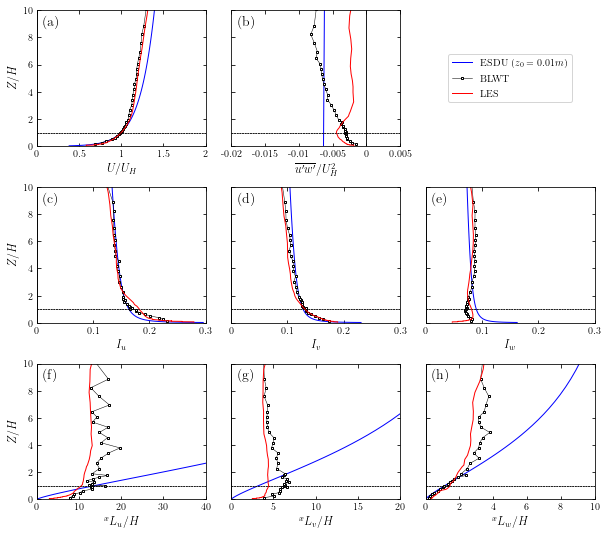

In [327]:
WT_cp.profile.name = 'BLWT'
LES_Cp.profile.name = 'LES'
es74 = esdu74_E2.toProfileObj()
es74.name = f'ESDU-74 ($z_0={es74.z0_Iu:.2g}m$)'
es74.SpectH.name = es74.name

es85 = esdu85_E2.toProfileObj()
es85.name = f'ESDU ($z_0={es85.z0_Iu:.2g}m$)'
es85.SpectH.name = es85.name

profs = wind.Profiles([es85, WT_cp.profile, LES_Cp.profile]) #, es74, es85])

fig, axs = profs.plotProfile_basic2(figsize=[10,9], hspace=0.3, wspace=0.15, sharey=True,
            yLimits=[0,10], showSubPlotLabels=True, #subPlotLabels={'U':'(a)', 'uw':'(b)', 'Iu':'(c)', 'Iv':'(d)', 'Iw':'(e)', 'xLu':'(f)', 'xLv':'(g)', 'xLw':'(h)'},
            xLimits_U=[0, 2], xLimits_uw=[-0.02, 0.005], 
            xLimits_Iu=[0,0.3], xLimits_Iv=[0,0.3], xLimits_Iw=[0,0.3], 
            xLimits_xLu=[0, 40], xLimits_xLv=[0,20], xLimits_xLw=[0,10], 
            kwargs_plt=[{'color': 'b', 'linewidth':1.0, 'linestyle': '-',      'marker': 'None', 'markersize':6, 'markerfacecolor':'w'},
                        {'color': 'k', 'linewidth':0.5, 'linestyle': '-',       'marker': 's', 'markersize':2, 'markerfacecolor':'w'},
                        {'color': 'r', 'linewidth':1.0, 'linestyle': '-',       'marker': 'None', 'markersize':3, 'markerfacecolor':'w'},
                        {'color': 'g', 'linewidth':1.0, 'linestyle': '--',       'marker': 'None', 'markersize':6, 'markerfacecolor':'w'},
                        {'color': 'k', 'linewidth':1.0, 'linestyle': '-.',      'marker': 'None', 'markersize':6, 'markerfacecolor':'w'},
                        ],
            lgnd_kwargs={'bbox_to_anchor': (0.5, 0.5), 'loc': 'center', 'ncol': 1},
            kwargs_ax={'gridMajor':False}
            )
# if saveFigs:
#     fig.savefig(figDir+"profile_basic2_simple.svg",format='svg',dpi=1200, bbox_inches='tight')
#     print(f"Figure saved to {figDir}profile_basic2.svg")


In [329]:
print(lesVel_E2.ReTau)

3638.4844187711096


Using z0_Iu.
Using z0_Iu.
Using z0_Iu.
Using z0_Iu.
Using z0_Iu.
Using z0_Iu.


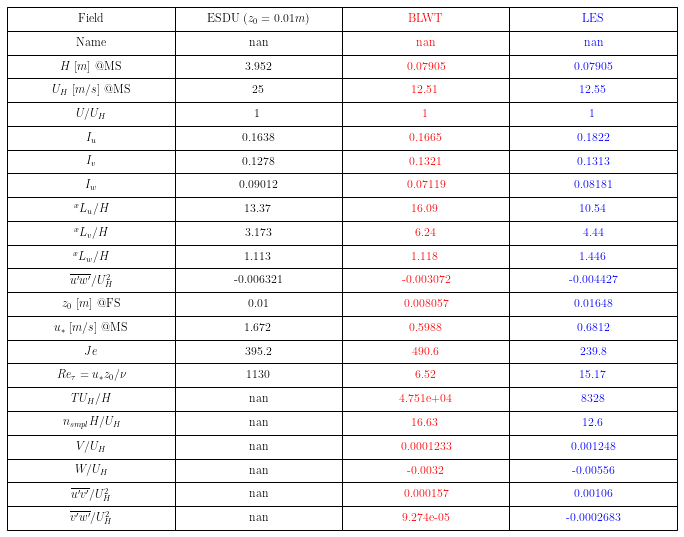

In [334]:
fig, _ = profs.plotParamsTable( colTxtColors=['k','r','b','g'], fontSz=12, 
                                params = 'all',
                                # params = wind.mathName(['H','Iu','Iv','Iw']),
                                )

fig.savefig(figDir+"paramsTable_vel.svg",format='svg',dpi=1200, bbox_inches='tight')

No velocity time history found for vonKarman. Skipping velocity statistics calculation.
Figure saved: D:/tempData_depot/simData_CandC/wt_tngE2_final/main.infl.t5.r2.s2/__plots//spectra.svg


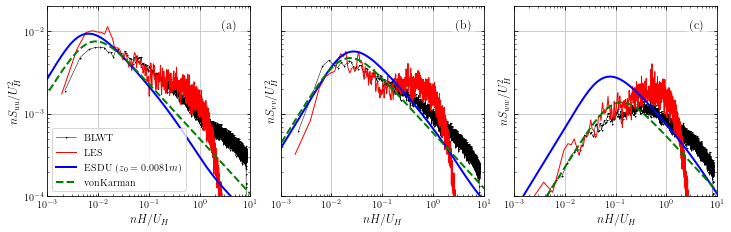

In [205]:
vonk = wind.profile(name='vonKarman', )
Sp = wtVel_E2.SpectH.copy()
n = np.logspace(-3, 3, 100)
Suu, Svv, Sww = wind.vonKarmanSpectra(n=n, U=Sp.U, Iu=Sp.Iu, Iv=Sp.Iv, Iw=Sp.Iw, xLu=Sp.xLu, xLv=Sp.xLv, xLw=Sp.xLw,)
vonk.SpectH = wind.spectra(name=vonk.name, Z=H, Suu=Suu, Svv=Svv, Sww=Sww, n=n, U=Sp.U, Iu=Sp.Iu, Iv=Sp.Iv, Iw=Sp.Iw, xLu=Sp.xLu, xLv=Sp.xLv, xLw=Sp.xLw,)

profss = wind.Profiles([WT_cp.profile, LES_Cp.profile, es85, vonk]) #, es74, es85])
LES_Cp.profile.SpectH.name = 'LES'
WT_cp.profile.SpectH.name = 'BLWT'

clb = 0
r = [1.0, clb, clb, 1.0]
b = [clb, clb, clb, 1.0]
kwargs_plt=[{'color': b, 'markerfacecolor':b, 'markeredgecolor':b, 'alpha':1, 'linewidth':0.5, 'linestyle': '-',    'marker': '+', 'markersize':1},
                            {'color': r, 'markerfacecolor':r, 'markeredgecolor':r, 'alpha':1, 'linewidth':1, 'linestyle': '-',    'marker': '', 'markersize':2},
                            {'color': 'b', 'linewidth':2, 'linestyle': '-',       'marker': 'None', 'markersize':6, 'markerfacecolor':'w'},
                            {'color': 'g', 'linewidth':2, 'linestyle': '--',      'marker': 'None', 'markersize':6, 'markerfacecolor':'w'},
                            {'color': 'k', 'linewidth':2, 'linestyle': '-.',      'marker': 'None', 'markersize':6, 'markerfacecolor':'w'},
                            ]

fig, _ = profss.plotSpectra(figsize=[12,3.5], normalize=True,
                        xLimits=[1e-3, 1e1], 
                        yLimits=[[1e-4,2e-2],[1e-4,2e-2],[1e-4,2e-2]], 
                        wspace=0.15, shareY=True, normU='U', normZ='Z',
                        subPlotLabel_xy=[0.9,0.9],
                        kwargs_plt=kwargs_plt,)
# fig.tight_layout()
# reduce the gap between subplots
# fig.subplots_adjust(wspace=0.37)

if saveFigs:
    fig.savefig(figDir+'spectra.svg', format='svg',dpi=600, bbox_inches='tight')
    print(f"Figure saved: {figDir}/spectra.svg")

0.6812341226173684
0.3639453215319163
1.6140565040222579


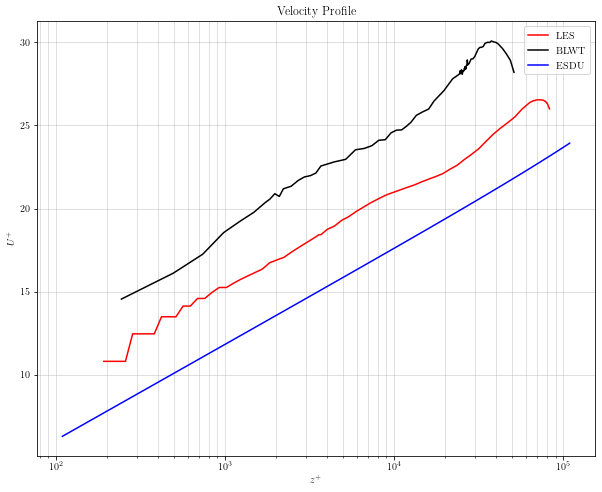

In [239]:
wtVel_E2.fluidDensity = 1.0
wtVel_E2.fluidKinematicViscosity = 1.48e-5
es85.fluidDensity = 1.0
es85.fluidKinematicViscosity = 1.48e-5 * (50*50)/25
print(lesVel_E2.shearVelocity)
print(wtVel_E2.shearVelocity)
print(es85.shearVelocity)
# print(lesVel_E2.fluidDensity)

fig = plt.figure(figsize=[10,8])
ax = fig.add_subplot()

ax.semilogx(lesVel_E2.Z_plus, lesVel_E2.U_plus, 'r', label='LES')
ax.semilogx(wtVel_E2.Z_plus, wtVel_E2.U_plus, 'k', label='BLWT')
ax.semilogx(es85.Z_plus, es85.U_plus, 'b', label='ESDU')
# ax.set_xlim([1, 1e4])
# ax.set_ylim([0, 25])
ax.set_xlabel('$z^+$')
ax.set_ylabel('$U^+$')
ax.legend()
ax.grid(True, which='both', axis='both', alpha=0.5)
ax.set_title('Velocity Profile')

plt.show()

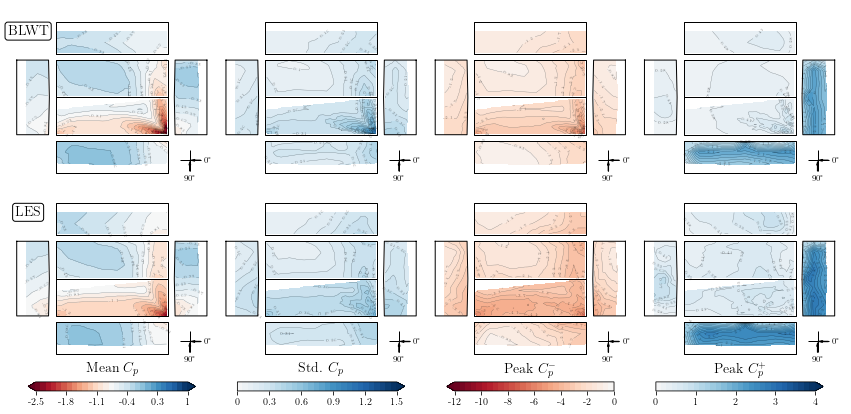

In [287]:
from matplotlib.ticker import FuncFormatter

fig, axs = plt.subplots(3,4,figsize=[15,10])
ax_cbar1 = axs[2,0]
ax_cbar2 = axs[2,1]
ax_cbar3 = axs[2,2]
ax_cbar4 = axs[2,3]

# fig.tight_layout(pad=0.0, w_pad=0.0, h_pad=0.0)
fig.subplots_adjust(wspace=0.0, hspace=0.0)

names = ['BLWT', 'LES']

for i, cp in enumerate([WT_cp, LES_Cp]):

    vals = np.linspace(-2.5, 1.0, 6)
    fld, fldrange, ticks = 'mean', [vals[0], vals[-1]], vals
    
    ax = axs[i,0]
    im = cp.plotTapCpStatContour(ax=ax, envelopeType='low',fieldName=fld,fldRange=fldrange,nLvl=30,title=wind.fullName(fld,abbreviate=True),)
    cp.plotEdges(ax=ax, showName=False)
    cp.plotAoA_definition(ax=ax, size=0.7, marginFactor=[1.0,0.5], location='lower right', AoAs=[0, 90], textOffsetFactor=3.0)
    ax.annotate(names[i], xy=(0.1, 0.9), xycoords='axes fraction', fontsize=14, ha='center', va='top',
                bbox=dict(boxstyle="round", fc="w", ec="k", pad=0.2))
    ax.axis('equal')
    ax.axis('off')
    if i == 1:
        ax_cbar1.axis('on')
        cbar = fig.colorbar(im[0], cax=ax_cbar1, orientation='horizontal',aspect=20,shrink=0.5,pad=0.08)
        cbar.set_ticks(ticks)
        cbar.ax.set_xlabel(wind.fullName(fld,abbreviate=True), fontsize=14, rotation=0, labelpad=10)
        cbar.ax.xaxis.set_major_formatter(FuncFormatter(lambda x, _: f'{x:.2g}'))
        cbar.ax.xaxis.set_label_position('top')
        pos = ax_cbar1.get_position()
        new_pos = [pos.x0+pos.width*0.1, pos.y0+pos.height*0.88, pos.width*0.8, pos.height*0.05]
        ax_cbar1.set_position(new_pos)


    vals = np.linspace(0, 1.5, 6)
    fld, fldrange, ticks = 'std', [vals[0], vals[-1]], vals
    ax = axs[i,1]
    im = cp.plotTapCpStatContour(ax=ax, envelopeType='high',fieldName=fld,fldRange=fldrange,nLvl=30,title=wind.fullName(fld,abbreviate=True), extend='max',
                                 cmap=wind.sub_cmap(cmap='RdBu', start=0.5, stop=1.0, n=30))
    cp.plotEdges(ax=ax, showName=False)
    cp.plotAoA_definition(ax=ax, size=0.7, marginFactor=[1.0,0.5], location='lower right', AoAs=[0, 90], textOffsetFactor=3.0)
    ax.axis('equal')
    ax.axis('off')
    if i == 1:
        ax_cbar2.axis('on')
        cbar = fig.colorbar(im[0], cax=ax_cbar2, orientation='horizontal',aspect=20,shrink=0.5,pad=0.08)
        cbar.set_ticks(ticks)
        cbar.ax.set_xlabel(wind.fullName(fld,abbreviate=True), fontsize=14, rotation=0, labelpad=10)
        cbar.ax.xaxis.set_major_formatter(FuncFormatter(lambda x, _: f'{x:.2g}'))
        cbar.ax.xaxis.set_label_position('top')
        pos = ax_cbar2.get_position()
        new_pos = [pos.x0+pos.width*0.1, pos.y0+pos.height*0.88, pos.width*0.8, pos.height*0.05]
        ax_cbar2.set_position(new_pos)


    vals = np.linspace(-12.0, 0, 7)
    fld, fldrange, ticks = 'peakMin', [vals[0], vals[-1]], vals
    ax = axs[i,2]
    im = cp.plotTapCpStatContour(ax=ax, envelopeType='low',fieldName=fld,fldRange=fldrange,nLvl=30,title=wind.fullName(fld,abbreviate=True), extend='min',
                                 cmap=wind.sub_cmap(cmap='RdBu', stop=0.5, n=30))
    cp.plotEdges(ax=ax, showName=False)
    cp.plotAoA_definition(ax=ax, size=0.7, marginFactor=[1.0,0.5], location='lower right', AoAs=[0, 90], textOffsetFactor=3.0)
    ax.axis('equal')
    ax.axis('off')
    if i == 1:
        ax_cbar3.axis('on')
        cbar = fig.colorbar(im[0], cax=ax_cbar3, orientation='horizontal',aspect=20,shrink=0.7,pad=0.08)
        cbar.set_ticks(ticks)
        cbar.ax.set_xlabel(wind.fullName(fld,abbreviate=True), fontsize=14, rotation=0, labelpad=10)
        cbar.ax.xaxis.set_major_formatter(FuncFormatter(lambda x, _: f'{x:.2g}'))
        cbar.ax.xaxis.set_label_position('top')
        pos = ax_cbar3.get_position()
        new_pos = [pos.x0+pos.width*0.1, pos.y0+pos.height*0.88, pos.width*0.8, pos.height*0.05]
        ax_cbar3.set_position(new_pos)


    vals = np.linspace(0, 4.0, 5)
    fld, fldrange, ticks = 'peakMax', [vals[0], vals[-1]], vals
    ax = axs[i,3]
    im = cp.plotTapCpStatContour(ax=ax, envelopeType='high',fieldName=fld,fldRange=fldrange,nLvl=30,title=wind.fullName(fld,abbreviate=True), extend='max',
                                 cmap=wind.sub_cmap(cmap='RdBu', start=0.5, stop=1.0, n=30))
    cp.plotEdges(ax=ax, showName=False)
    cp.plotAoA_definition(ax=ax, size=0.7, marginFactor=[1.0,0.5], location='lower right', AoAs=[0, 90], textOffsetFactor=3.0)
    ax.axis('equal')
    ax.axis('off')
    if i == 1:
        ax_cbar4.axis('on')
        cbar = fig.colorbar(im[0], cax=ax_cbar4, orientation='horizontal',aspect=20,shrink=0.7,pad=0.08)
        cbar.set_ticks(ticks)
        cbar.ax.set_xlabel(wind.fullName(fld,abbreviate=True), fontsize=14, rotation=0, labelpad=10)
        cbar.ax.xaxis.set_major_formatter(FuncFormatter(lambda x, _: f'{x:.2g}'))
        cbar.ax.xaxis.set_label_position('top')
        pos = ax_cbar4.get_position()
        new_pos = [pos.x0+pos.width*0.1, pos.y0+pos.height*0.88, pos.width*0.8, pos.height*0.05]
        ax_cbar4.set_position(new_pos)

# if saveFigs:
#     fileName = figDir+f"CpContour.svg"
#     fig.savefig(fileName,format='svg',dpi=600, bbox_inches='tight')
#     print(f"Figure saved to {fileName}")
    

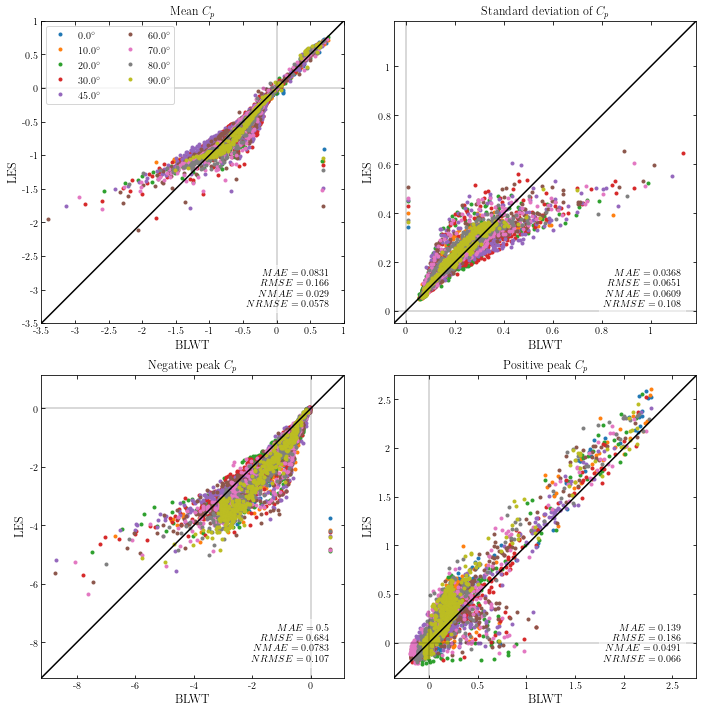

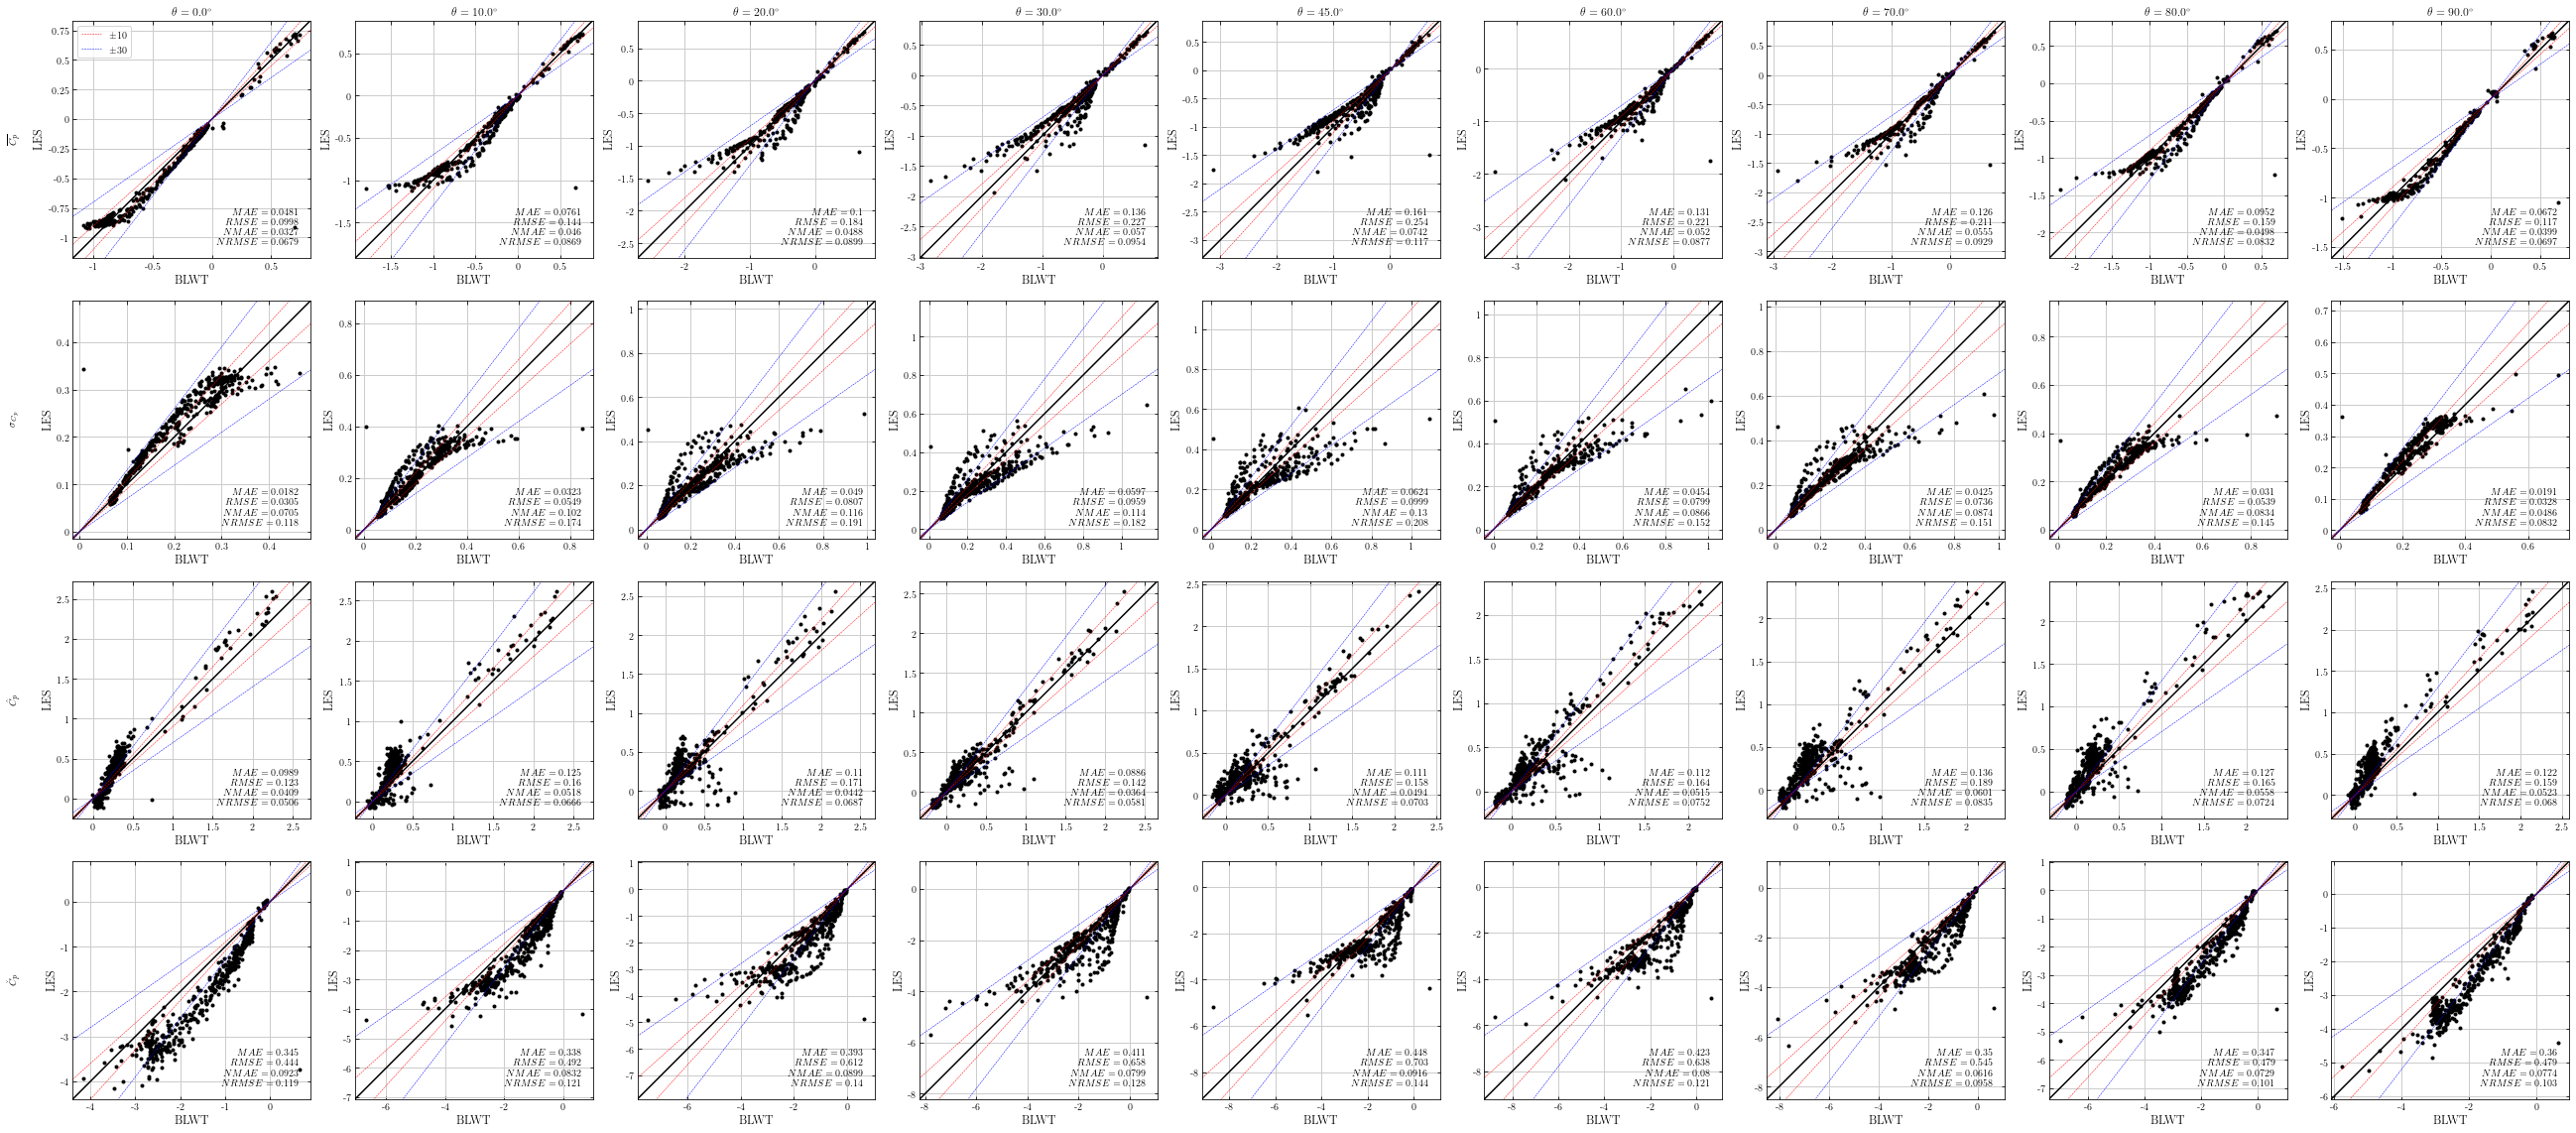

In [291]:

fig, _ = validator.plotError_CpStats(modelLabel='LES', targetLabel='BLWT', percentLinesAt=[], figsize_per_ax=[5,5], 
                                     showErrTxt=True, fields=['mean','std','peakMin','peakMax'], nPltCols=2,
                                    xyLims={'mean':[-3.5, 1], 'skewness': [-5, 3], 'kurtosis': [-5, 30]}, cols=wind.def_cols, showLegend=True,
                                    kwargs_legend={'loc': 'upper left', 'ncol': 2},
                                    )

# fig.savefig(figDir+'CpStatsErrorNew_small.svg', bbox_inches='tight', dpi=300)
# print(f"Figure saved: {figDir}CpStatsErrorNew_small.svg")

# # _ = validator.plotError_CpStats(xyLims={'skewness': [-5, 3], 'kurtosis': [-0.5, 30]})
fig, _ = validator.plotError_CpStats_perAoA(targetLabel='BLWT', modelLabel='LES', )
fig.savefig(figDir+'CpStatsError_perAoA.svg', bbox_inches='tight', dpi=300)


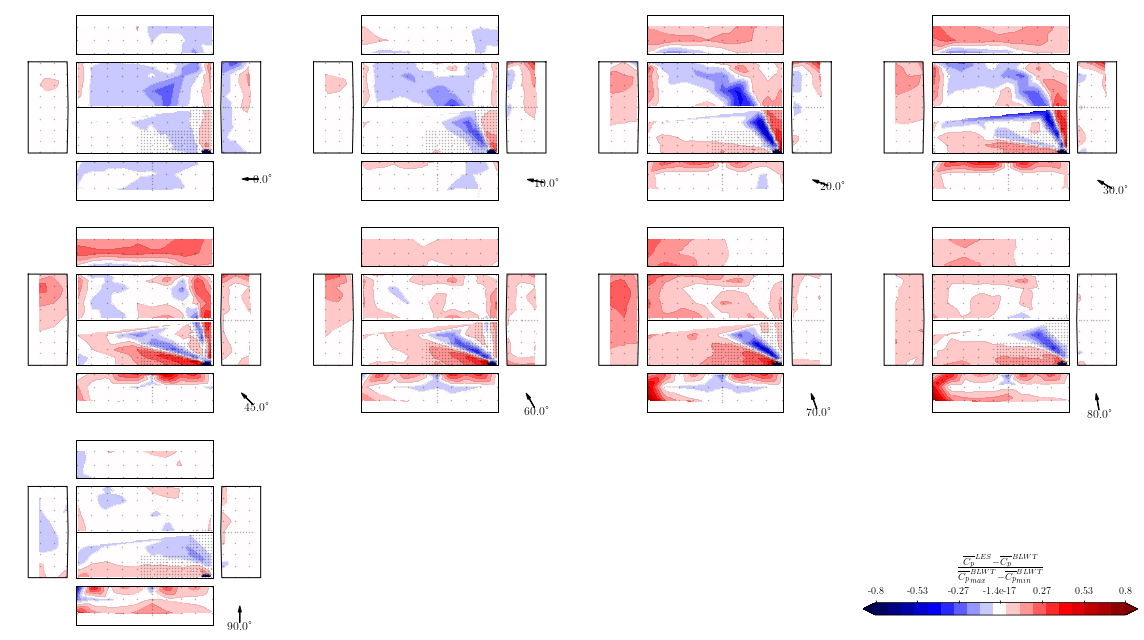

In [289]:


# # fld, fldRange = 'std', [-0.3, 0.3]
fld, fldRange = 'mean', [-0.8, 0.8]
fig, _ = validator.plotError_contour_CpStats(fieldName=fld, nLvl=20, figsize_per_ax=[4,3], AoAs=LES_Cp.AoA, #[0,20,45,80],
                                             nCols=4, colBarOrientation='horizontal', tLbl='BLWT', mLbl='LES',
                                            showValuesOnContour=True, cmap='seismic',
                                            fldRange=fldRange,
                                            )

# fig.savefig(figDir+'CpStatsError_contour_'+fld+'_new.svg', bbox_inches='tight')


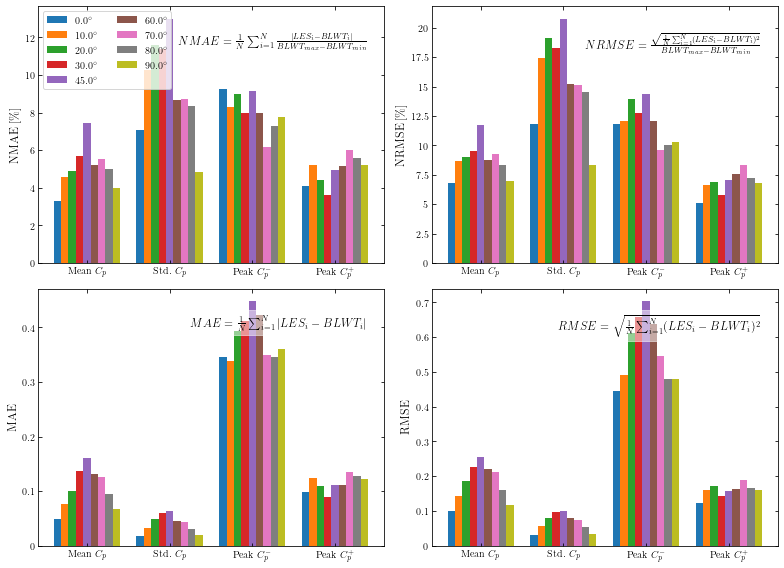

In [292]:
fig, _ = validator.plotError_barChart_CpStats(fields=['mean','std','peakMin','peakMax'], lumpAllAoAs=False, errorType=['NMAE','NRMSE','MAE','RMSE',], kwargs_legend={'loc':'upper left', 'ncol':2},
                                         cols=wind.def_cols, 
                                        figsize_per_ax=[5.5,4], nPltCols=2, #yLims={'NMAE':[0, 25], 'NRMSE':[0, 30], },
                                        kwargs_annotation={'xy':(0.95, 0.9), 'xycoords':'axes fraction', 'ha':'right', 'va':'top', 'backgroundcolor':[1,1,1,0.5], 'fontsize':12},
                                   )

fig.savefig(figDir+'CpStatsError_barChart_small.svg', bbox_inches='tight')

### $C_p$ Plots

In [297]:
print(WT_cp.T_star)

[809.56740427 808.90021912 806.2356121  805.07125065 804.28821186
 805.36333394 804.29525367 803.24948432 803.66960032]


Number of member bldgs: 2


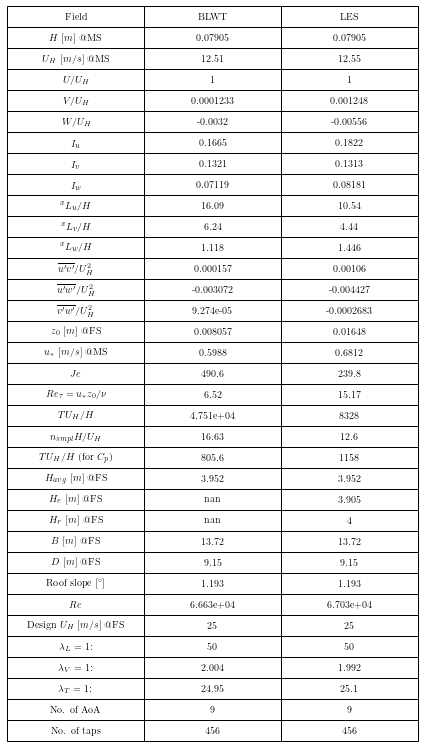

In [335]:
WT_cp.name = 'BLWT'
cps = wind.BldgCps([WT_cp, LES_Cp])

fig, _ = cps.plotParamsTable()

if saveFigs:
    fig.savefig(figDir+"paramsTable.svg",format='svg',dpi=1200, bbox_inches='tight')


#### Local pressure

In [34]:
# LES_Cp.plotTapCpStatsPerAoA(fldRange=[-8,2.3],#xticks=np.round(LES_Cp.AoA,0),
#                             pageNo_xy=(0.5,0.06),nCols=13, figsize=[25,20])
# wtCp_tngE2.plotTapCpStatsPerAoA(fldRange=[-8,2.3],xticks=np.round(wtCp_tngE2.AoA,0),pageNo_xy=(0.5,0.06),nCols=13, figsize=[25,20])

# lesCp_E2.plotTapCpStatsPerAoA(fldRange=[-8,2.3],xticks=np.round(lesCp_E2.AoA,0),pageNo_xy=(0.5,0.06),nCols=13, figsize=[25,20])
# wtCp_tngE2.plotTapCpStatsPerAoA(fldRange=[-8,2.3],xticks=np.round(wtCp_tngE2.AoA,0),pageNo_xy=(0.5,0.06),nCols=13, figsize=[25,20])

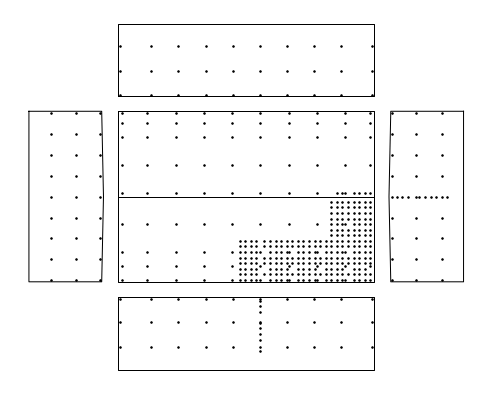

In [323]:
fig, ax = plt.subplots(figsize=(10, 5))
bldg.plotTaps(ax=ax)
bldg.plotEdges(ax=ax, showName=False)
ax.set_aspect('equal')
ax.axis('off')
plt.show()

if saveFigs:
    fig.savefig(figDir+'tapLayout.svg', bbox_inches='tight')

#### Area averaged load

Computing C&C Load factor for BLWT ...
full_scale_duration = 127.36488050241192
z0 = 0.000161m (@MS), 0.00806m (@FS)

Calculating the lumped reference velocity conversion factors for C&C wind loads.
		From 		---> 	 To	===>	Factor
Type		simulated 	---> 	 ASCE
z0		0.00806 		---> 	 0.03	===>	1.17
Z		3.95 		---> 	 10	===>	0.756
gust_dur	127.36 		---> 	 3	===>	0.591
			COMBINED FACTOR			0.5218

C&C factor for case BLWT = 0.5218297987676067
Computing C&C Load factor for LES ...
full_scale_duration = 183.01295157670853
z0 = 0.00033m (@MS), 0.0165m (@FS)

Calculating the lumped reference velocity conversion factors for C&C wind loads.
		From 		---> 	 To	===>	Factor
Type		simulated 	---> 	 ASCE
z0		0.0165 		---> 	 0.03	===>	1.08
Z		3.95 		---> 	 10	===>	0.731
gust_dur	183.01 		---> 	 3	===>	0.559
			COMBINED FACTOR			0.4411

C&C factor for case LES = 0.4411276554985699


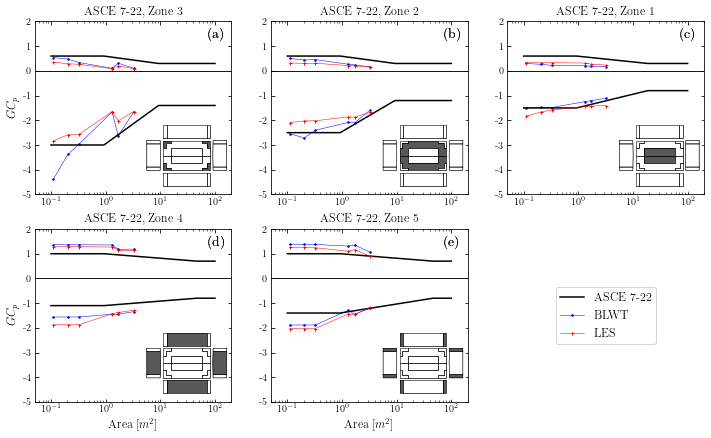

Saved figure: D:/tempData_depot/simData_CandC/wt_tngE2_final/main.infl.t5.r2.s2/__plots/CandC_Fig_E_iso.svg


In [599]:
fig = plt.figure(figsize=[12,7])
plt.tight_layout()

NumZones = bldg.NumZones
nCols = min(3, NumZones)
nRows = int(np.ceil(NumZones/nCols))
axs = fig.subplots(nRows, nCols, sharex=False, sharey=False)

for I, zKey in enumerate(bldg.zoneDictKeys):
    i, j = np.unravel_index(I, axs.shape)
    ax = axs[i,j]
    ax.set_title(zKey)
    if i == axs.shape[0]-1:
        ax.set_xlabel(r'Area [$m^2$]')
    if j == 0:
        ax.set_ylabel(r"$GC_p$")
    ax.set_xlim([0.05,200])
    ax.set_ylim([-5,2])

    wind.formatAxis(ax, gridMajor=False, gridMinor=False)

directionalityFactor = 1.0 #0.85
cols = ['b','r','b','g','m','c']
mrkrs = ['.','+','^','v','<','>']
ms = [3,3,3,3,3,3]
names = ['BLWT', 'LES']
for i, cp in enumerate([WT_cp, LES_Cp]):
    if i == 0:
        overlayThese=[
                # windCodes.NBCC2020_CpCg(Figure='4.1.7.6.-C', subfig='a'),
                windCodes.ASCE7_22_GCp(Figure='30.3-2C', subfig='a', outAs='ASCE'),
                ]
        overlayFactors=[
            # 1.0/(directionalityFactor * (windCodes.getDurstFactor(3.0))**2),
            1.0,
            ]
        kwargs_overlay=(
            {'color':'k',}, 
            # {'color':'k', 'linestyle':'--'},
            )
    else:
        overlayThese=None
        overlayFactors=None
        kwargs_overlay=({},)

    _ = cp.plotCandC_load(fig=fig, axs=axs, 
                            # figSize=[12.5,12.5], 
                            sharex=False, sharey=False,
                            plotExtremesPerNominalArea=True, areaFactor=areaFactor_toFSm2,
                            # xLimits=[0.1,100], yLimits=[-5,1],
                            debugMode=True,
                            CandCLoadFormat='ASCE',
                            yLabel=r"$GC_p$",
                            label_min=names[i], label_max=None,
                            kwargs_min={'color':cols[i], 'marker':mrkrs[i], 'ms':3, 'ls':'-', 'lw': 0.5},
                            kwargs_max={'color':cols[i], 'marker':mrkrs[i], 'ms':3, 'ls':'-', 'lw': 0.5},
                            overlayThese=overlayThese,
                            overlayFactors=overlayFactors,
                            kwargs_overlay=kwargs_overlay,
                            legend_ax_idx=5,
                            kwargs_legend={'loc':'center', 'fontsize':12},
                            subplotLabels=['(a)','(b)','(c)','(d)','(e)',''], subplotLabels_xy=[0.88,0.9],
                            kwargs_ax={'gridMinor':True},
                            insetBounds=[0.55,0.01,0.445,0.43], insetAxAlpha=0.2,
                            )


plt.show()

# if saveFigs:
#     fig.savefig(figDir+"CandC_small.svg",format='svg',dpi=1200, bbox_inches='tight')
#     print(f"Saved figure: {figDir}CandC_Fig_E_iso.svg")


# Validate the aerodynamics with line plots (to be implemented)

In [134]:
fc = faces_ASCE[0].copy()
fc.basisVectors_plt = [[1, 0], [0, 1]]

origin:  [-0.075, 0.11]
basisVectors:  [[ 0.21242964 -0.97717636]
 [ 0.97717636  0.21242964]]


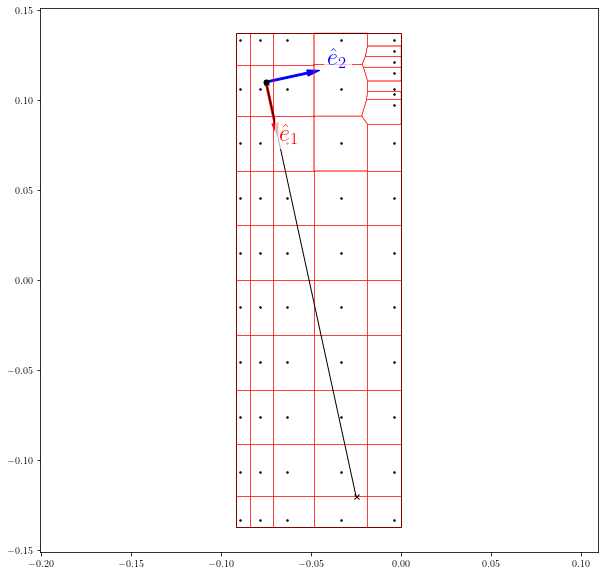

In [586]:

# fc.plot(figSize=[6,10])

# print(fc.basisVectors_plt)
# print(fc.basisVectors)
# print(fc.origin_plt)

lineAB = windCAD.samplingLine(name='Line-AB',parentFace=fc, start_xy=[-0.075,0.11], end_xy=[-0.025,-0.12], label='AB', dist_tolerance=0.005,
                              debug=True)

# lineAB.plot(figSize=[6,10])

In [348]:
print(lesVel_E2.UofT.shape)

(71, 104918)


C:\Users\Tsinu\AppData\Local\Temp\ipykernel_84236\3965750840.py:68: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(['$p_0$', '$p_1$', '$p_2$', '...', '$p_N$'])


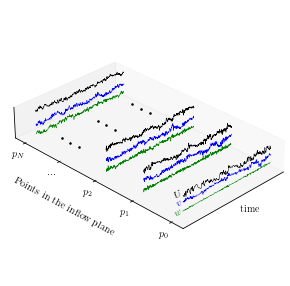

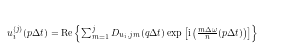

In [540]:
from mpl_toolkits.mplot3d import Axes3D

# open a 3D plot figure
fig = plt.figure(figsize=[5,5])
ax = fig.add_subplot(projection='3d')

# add a bunch of 2D plots with different fixed z values
i = 2000
dv = 0.0
dw = -10.0
lw = 0.5
x = lesVel_E2.t[:i]

y1 = lesVel_E2.UofT[8,:i]
y2 = lesVel_E2.UofT[10,:i]
y3 = lesVel_E2.UofT[12,:i]
y4 = lesVel_E2.UofT[14,:i]
y5 = lesVel_E2.UofT[16,:i]

# plot the 2D plots
I, zs = 2, 0.0
ax.plot(x, lesVel_E2.UofT[I,:i], zs=zs, zdir='y', color='k', lw = lw, label='$U(t)$')
ax.plot(x, lesVel_E2.VofT[I,:i]+dv, zs=zs, zdir='y', color='b', lw = lw, label='$v(t)$')
ax.plot(x, lesVel_E2.WofT[I,:i]+dw, zs=zs, zdir='y', color='g', lw = lw, label='$w(t)$')

I, zs = 20, 0.1
ax.plot(x, lesVel_E2.UofT[I,:i], zs=zs, zdir='y', color='k', lw = lw)
ax.plot(x, lesVel_E2.VofT[I,:i]+dv, zs=zs, zdir='y', color='b', lw = lw)
ax.plot(x, lesVel_E2.WofT[I,:i]+dw, zs=zs, zdir='y', color='g', lw = lw)

I, zs = 30, 0.2
ax.plot(x, lesVel_E2.UofT[I,:i], zs=zs, zdir='y', color='k', lw = lw)
ax.plot(x, lesVel_E2.VofT[I,:i]+dv, zs=zs, zdir='y', color='b', lw = lw)
ax.plot(x, lesVel_E2.WofT[I,:i]+dw, zs=zs, zdir='y', color='g', lw = lw)

# plot dots between zs = 0.25 and zs = 0.45
ax.plot([0.275, 0.3, 0.325], [0,0,0], zs=0.0, zdir='x', color='k', lw = 1, ls='None', marker='.', ms=3)
ax.plot([0.275, 0.3, 0.325], [0,0,0], zs=0.4, zdir='x', color='k', lw = 1, ls='None', marker='.', ms=3)
ax.plot([0.275, 0.3, 0.325], [0,0,0], zs=0.8, zdir='x', color='k', lw = 1, ls='None', marker='.', ms=3)


I, zs = 48, 0.4
ax.plot(x, lesVel_E2.UofT[I,:i], zs=zs, zdir='y', color='k', lw = lw)
ax.plot(x, lesVel_E2.VofT[I,:i]+dv, zs=zs, zdir='y', color='b', lw = lw)
ax.plot(x, lesVel_E2.WofT[I,:i]+dw, zs=zs, zdir='y', color='g', lw = lw)


ax.text(0, 0.0, 8, r'$U$', zdir='x', color='k', #fontsize=10,
         verticalalignment='center', 
        horizontalalignment='right', bbox=dict(boxstyle="round", fc="None", ec="None", pad=0.2))
ax.text(0, 0.0, -2, r'$v$', zdir='x', color='b',
        fontsize=10, verticalalignment='center', 
        horizontalalignment='right', bbox=dict(boxstyle="round", fc="None", ec="None", pad=0.2))
ax.text(0, 0.0, -12, r'$w$', zdir='x', color='g',
        fontsize=10, verticalalignment='center', 
        horizontalalignment='right', bbox=dict(boxstyle="round", fc="None", ec="None", pad=0.2))


# ax.legend(bbox_to_anchor=(0.8, 0.8), loc='center', ncol=1)
ax.set_xlim(-0.1, max(x))
# ax.set_xlim(0, 1)
# ax.set_zlim(-0.1, 0.1)
ax.set_xlabel('time', labelpad=-10)
ax.set_ylabel('Points in the inflow plane', labelpad=20)
# ax.set_zlabel('z')

ax.set_zticklabels([])
ax.set_yticklabels(['$p_0$', '$p_1$', '$p_2$', '...', '$p_N$'])
ax.set_xticklabels([])
ax.set_zticks([])
ax.set_yticks([0, 0.1, 0.2, 0.3, 0.4])
ax.set_xticks([])

ax.view_init(elev=30, azim=-135)

ax.set_box_aspect((0.6, 1, 0.15))

ax.grid(False)

# ax.auto_scale_xyz([-0.1, 0.1], [0, 1], [-0.1, 0.1])


plt.show()

# fig.savefig(figDir+'Inflow_schematic.svg', bbox_inches='tight', dpi=300)

# a separate simple figure for the equation
fig = plt.figure(figsize=[5,0.5])
ax = fig.add_subplot()

eqn = r'$u_i^{(j)}(p\Delta t) = \mathrm{Re} \left\{ \sum_{m=1}^{j} D_{u_i,jm}(q \Delta t) \exp \left[ \mathrm{i} \left( \frac{m \Delta \omega}{n} (p \Delta t) \right) \right] \right\} $'

ax.text(0, 0, eqn, ha='left', va='center', )

ax.axis('off')
plt.show()

# fig.savefig(figDir+'Inflow_schematic_eqn.svg', bbox_inches='tight', dpi=300)

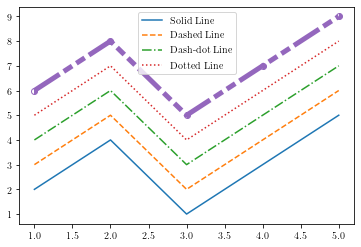

In [568]:
def_mk = ['o','s','^','v','<','>','D','P','X','*','+','x','1','2','3','4','8','p','h','H','d','|','_',
          {'marker': 'o', 'fillstyle': 'full'},
          {'marker': 'o', 'fillstyle': 'left'},
          {'marker': 'o', 'fillstyle': 'right'},
          ]
def_ls = ['-','--','-.',':', 
          {'ls':'--', 'dashes':(6,1,2,1,2,1), 'dash_capstyle':'butt'}, 
          {'ls':'--', 'dash_capstyle':'butt'}, 
          {'ls':'--', 'dash_capstyle':'projecting'}]

import matplotlib.pyplot as plt

# Define your custom line style as a tuple of on-off ink lengths
custom_line_style = (6, 1, 1, 1)

# Plotting example with the custom line style
x = [1, 2, 3, 4, 5]
y = [2, 4, 1, 3, 5]


plt.plot(x, y, linestyle='-', label='Solid Line')
plt.plot(x, [i+1 for i in y], linestyle='--', label='Dashed Line')
plt.plot(x, [i+2 for i in y], linestyle='-.', label='Dash-dot Line')
plt.plot(x, [i+3 for i in y], linestyle=':', label='Dotted Line')

# Use the custom line style
plt.plot(x, [i+4 for i in y], lw=5, 
        #  linestyle='--', dashes=custom_line_style, label='Custom Line Style', dash_capstyle='butt', dash_joinstyle='miter', 
         **def_ls[4], **def_mk[-1], )

plt.legend()
plt.show()
